## Project: Toxic Comment Filter

The present project aims to develop a Deep Learning multi-label classification model for filtering toxic comments within social network platforms.
To achieve this goal, the project is divided into several distinct steps:

* **Data Exploration**: In this phase, we will delve into the dataset to gain a better understanding of the data;
* **Data Pre-processing**: The collected dataset will undergo a comprehensive data cleaning and pre-processing pipeline. This includes tasks such as text tokenization to transform the raw data into a format suitable for training Deep Learning models;
* **Model Building**: The next step is to train a Deep Learning model on the preprocessed text data, capable of multi-label classification;
* **Model Evaluation and Prediction**: In the final phase, we will assess the performance of the trained models using appropriate evaluation metrics. The goal is to select the best-performing model based on these metrics, showcasing its ability to detect and filter toxic comments effectively.<br>
    
The difference between *multi-class* and *multi-label* classification is that in *multi-class* problems the classes are mutually exclusive, whereas for *multi-label* problems each label represents a different classification task. We will see how to handle this in the Model Building section.

### Table of Contents

* 1. [Data Exploration](#1)
   * [1.1. Data import and control](#2)
   * [1.2. EDA](#3)
   * [1.3. Checking for missing values](#4)
   * [1.4. Multi-label classification problem with imbalanced dataset](#5)
   
* 2. [Pre-processing](#6)
   * [2.1. Train-test-val split](#7)
   * [2.2. Conversion in sequences](#8)

* 3. [Model building](#9)
   * [3.1. Choice of the proper metric and defining the early stopping](#10)
   * [3.2. Simple RNN Model](#11)
   * [3.3. Weighted Simple RNN Model](#12)
   * [3.4. Long Short-Term Memory (LSTM) and Gated Recurrent Unit (GRU) Model](#13)
   * [3.5. GRU Model](#14)
   * [3.6. Bidirectional GRU Model](#15)
   * [3.7. CNN-RNN Hybrid Model](#16)
   
* 4. [Final Model](#17)

<a id="1"> </a>
### 1.Data Exploration

<a id="2"> </a>
#### 1.1. Data import and control

Let's begin with a bit of Data Exploration. First of all, let's import the dataset:

In [1]:
#basics
import pandas as pd
import numpy as np
import pickle

#no warnings
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.filterwarnings("ignore")
import os
os.environ['TF_CPP_MIN_LOG_LEVEL']= '3'
import tensorflow as tf
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)

#nlp
import string
import nltk
import re
nltk.download("stopwords")
from nltk.corpus import stopwords
from nltk.stem import SnowballStemmer
from keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences


#viz
import matplotlib.pyplot as plt
from wordcloud import WordCloud ,STOPWORDS
import seaborn as sns
import plotly.express as px
from plotly.subplots import make_subplots
import plotly.graph_objects as go
import missingno as msno

#ml
from sklearn.model_selection import train_test_split
import tensorflow as tf
from keras.models import Sequential
from tensorflow.keras.layers import (
    Embedding,
    Conv1D,
    MaxPooling1D,
    LSTM,
    GRU,
    Dense,
    Dropout,
    Bidirectional,
    SimpleRNN,
    BatchNormalization
)
from tensorflow.keras.backend import clear_session
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.callbacks import Callback
from tensorflow_addons.metrics import HammingLoss
from tensorflow.keras.models import load_model
from sklearn.metrics import precision_score, recall_score
from sklearn.metrics import multilabel_confusion_matrix, classification_report
from sklearn.utils.class_weight import compute_class_weight
from tensorflow import keras

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\crist\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [2]:
BASE_URL = "https://s3.eu-west-3.amazonaws.com/profession.ai/datasets/"
df = pd.read_csv(BASE_URL+"Filter_Toxic_Comments_dataset.csv")

<a id="3"> </a>
#### 1.2. EDA

In [3]:
df.shape

(159571, 8)

In [4]:
df.head()

,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate,sum_injurious
0,Explanation\nWhy the edits made under my usern...,0,0,0,0,0,0,0
1,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0,0
2,"Hey man, I'm really not trying to edit war. It...",0,0,0,0,0,0,0
3,"""\nMore\nI can't make any real suggestions on ...",0,0,0,0,0,0,0
4,"You, sir, are my hero. Any chance you remember...",0,0,0,0,0,0,0


This dataset consists of 159571 comments, each categorized into one or more of six toxicity categories: `toxic`, `severe_toxic`, `obscene`, `threat`, `insult`, and `identity_hate`. Additionally, it includes a derived variable named `sum_injurious`, calculated by summing the values of the category variables. From the latter variable, it is possible to define the `clean` variable to see how many comments are non-toxic:

In [5]:
df.insert(df.columns.get_loc("sum_injurious"),
          "clean",
          df["sum_injurious"].apply(lambda x: 1 if x==0 else 0))
df.head()

,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate,clean,sum_injurious
0,Explanation\nWhy the edits made under my usern...,0,0,0,0,0,0,1,0
1,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0,1,0
2,"Hey man, I'm really not trying to edit war. It...",0,0,0,0,0,0,1,0
3,"""\nMore\nI can't make any real suggestions on ...",0,0,0,0,0,0,1,0
4,"You, sir, are my hero. Any chance you remember...",0,0,0,0,0,0,1,0


<a id="4"> </a>
#### 1.3. Checking for missing values

In [6]:
df.info() #check features type and missing values

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 159571 entries, 0 to 159570
Data columns (total 9 columns):
 #   Column         Non-Null Count   Dtype 
---  ------         --------------   ----- 
 0   comment_text   159571 non-null  object
 1   toxic          159571 non-null  int64 
 2   severe_toxic   159571 non-null  int64 
 3   obscene        159571 non-null  int64 
 4   threat         159571 non-null  int64 
 5   insult         159571 non-null  int64 
 6   identity_hate  159571 non-null  int64 
 7   clean          159571 non-null  int64 
 8   sum_injurious  159571 non-null  int64 
dtypes: int64(8), object(1)
memory usage: 11.0+ MB


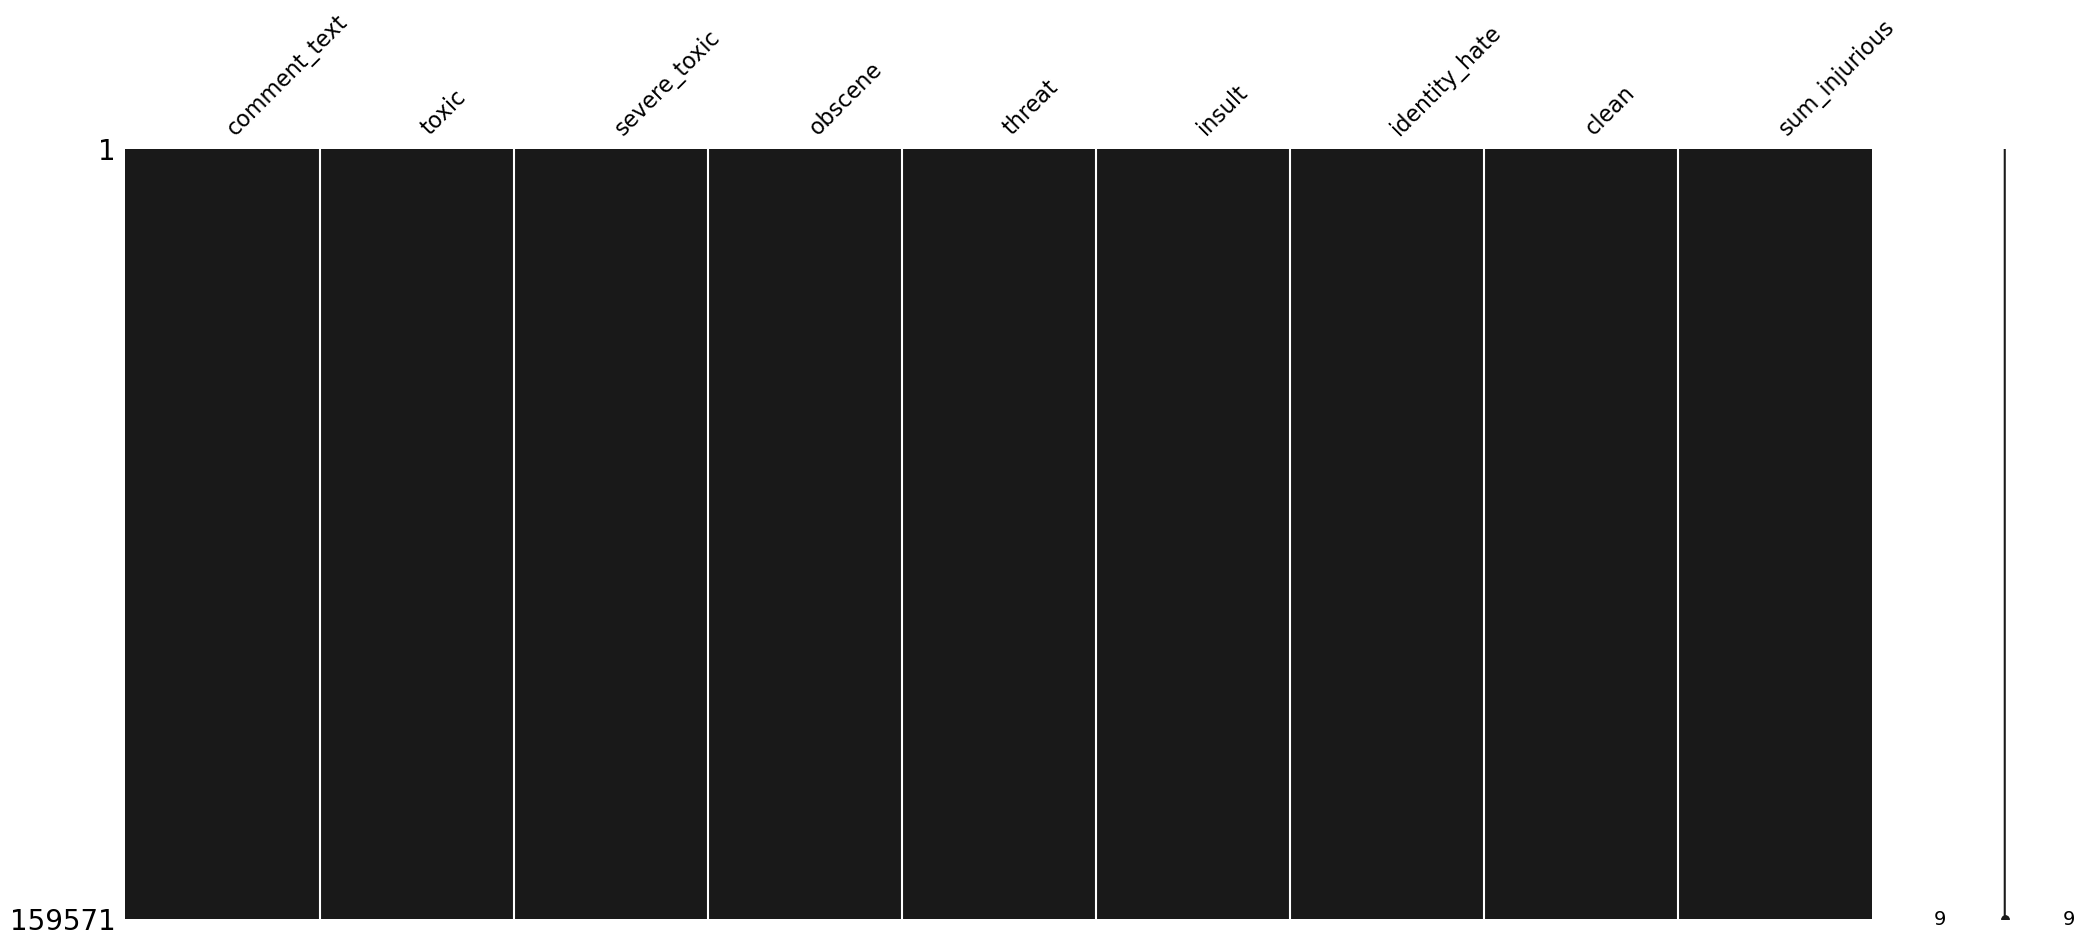

In [7]:
# Visualizing missing values
#df.isnull().sum().any()
msno.matrix(df, color=" 0.1")
plt.show()

There are no missing values

<a id="5"> </a>
#### 1.4. Multi-label classification problem with imbalanced dataset

Toxic comment classification is a multi-label text classification problem with a highly imbalanced dataset. This can be clearly seen by the following barplot, that shows the number of comments in each category:

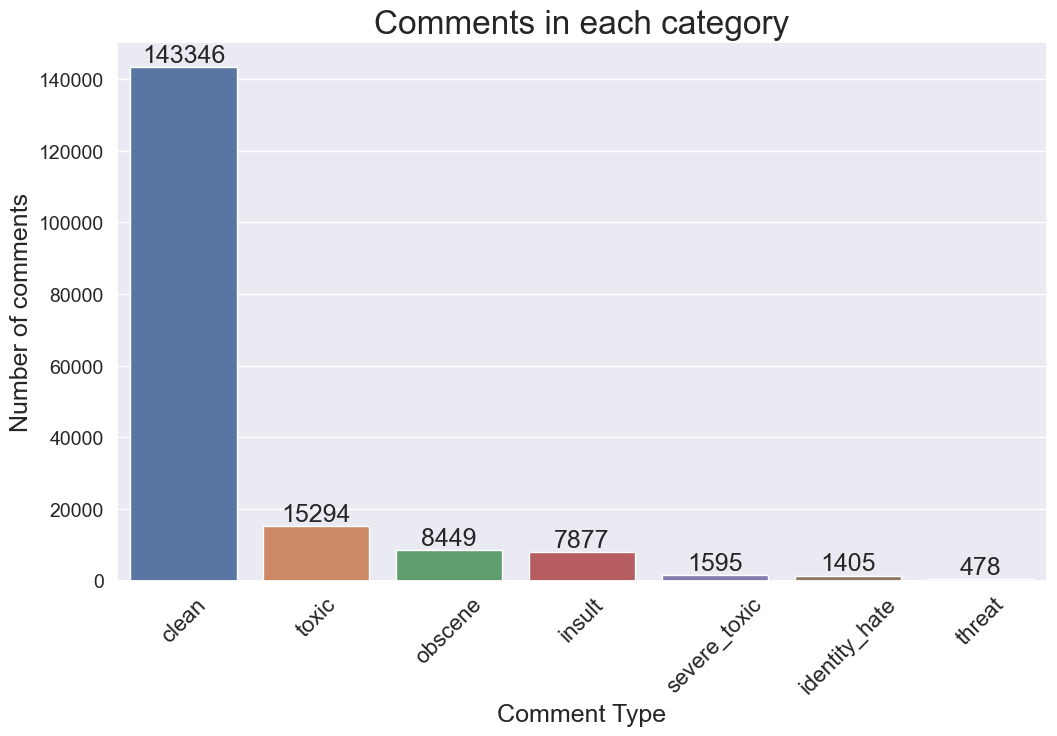

In [8]:
def show_barplot(x, y, title=None, xlabel=None, ylabel=None, xtickrotation=True):
    """
    Display a bar plot.

    Parameters:
    - x: Data for the x-axis.
    - y: Data for the y-axis.
    - ax: Axis object (optional, default=None).
    - title: Title of the plot (optional, default=None).
    - xlabel: Label for the x-axis (optional, default=None).
    - ylabel: Label for the y-axis (optional, default=None).
    - xtickrotation: Enable rotation of x-axis labels (optional, default=True).
    - figsize: Size of the plot (optional, default=(12, 7)).
    """
    sns.set(font_scale=2)
    plt.figure(figsize=(12,7))
    ax = sns.barplot(x=x, y=y)
    if title is not None:
        plt.title(title, fontsize=24)
    if xlabel is not None:
        plt.xlabel(xlabel, fontsize=18)
    if ylabel is not None:
        plt.ylabel(ylabel, fontsize=18)
    rects = ax.patches
    for rect in rects:
        height = rect.get_height()
        ax.text(rect.get_x() + rect.get_width()/2, height + 5,
                int(height), fontsize=18,
                ha='center', va='bottom')
    if xtickrotation:
        plt.xticks(rotation=45, ha='center', fontsize=16)
    else:
        plt.xticks(ha='center', fontsize=16)
    plt.yticks(fontsize=14)
    plt.show()


categories = df.iloc[:,1:-1].sum().sort_values(ascending=False).index
counts = df.iloc[:,1:-1].sum().sort_values(ascending=False).values
show_barplot(categories,counts,"Comments in each category", "Comment Type", "Number of comments")

Furthermore, the following bar plot illustrates the distribution of comments based on the number of labels they have:

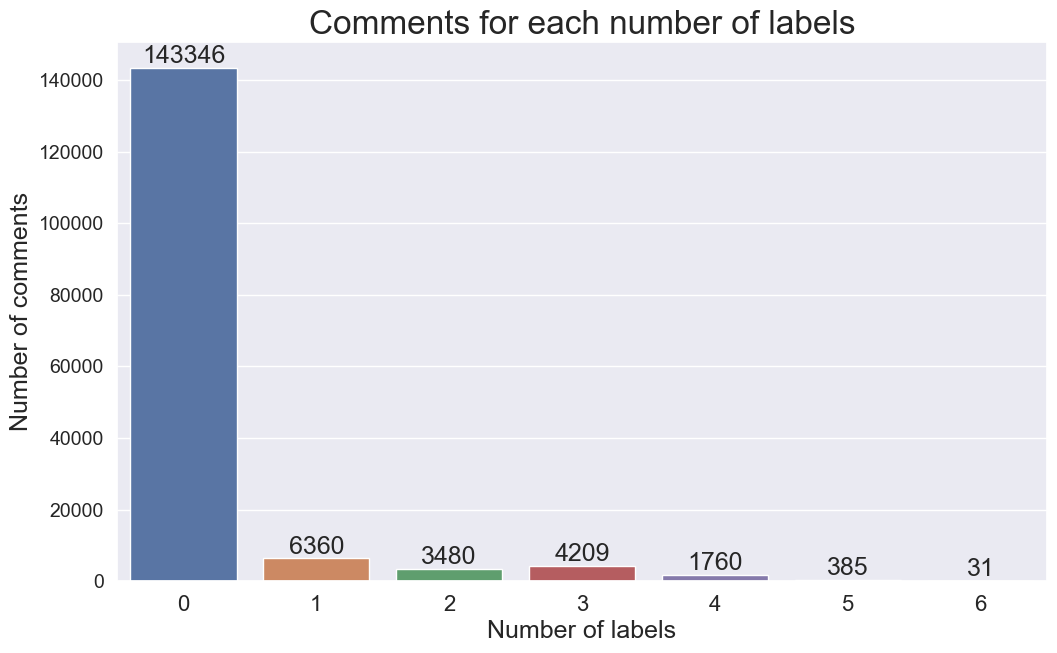

In [9]:
categories = df["sum_injurious"].value_counts().index
counts = df["sum_injurious"].value_counts().values
show_barplot(categories,counts,"Comments for each number of labels",
             "Number of labels", "Number of comments", xtickrotation=False)

Here's the information conveyed by the two bar plots:
* The dataset exhibits a significant imbalance, with the majority of comments being clean (143,346), while, for instance, there are only 478 comments labeled as "threat". This should be taken into account during the training of the Deep Learning model.
* There is a decreasing trend in the number of comments as the number of labels increases, with only 31 comments having all six labels.

Vediamo ora la word cloud che mostra le parole più frequenti nei commenti che non sono considerati dannosi

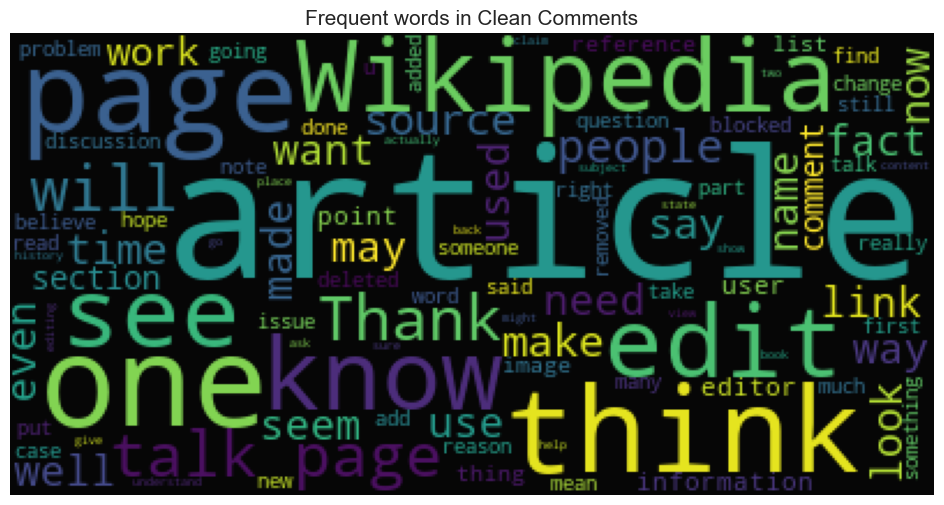

In [10]:
stopword=set(STOPWORDS)

subset=df[df["sum_injurious"]==0]
text=subset.comment_text.values
wc= WordCloud(background_color="black",max_words=2000,stopwords=stopword)
wc.generate(" ".join(text))
plt.figure(figsize=(12,6))
plt.axis("off")
plt.title("Frequent words in Clean Comments", fontsize=15)
plt.imshow(wc.recolor(colormap= 'viridis' , random_state=17), alpha=0.98)
plt.show()

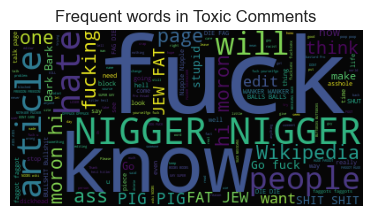

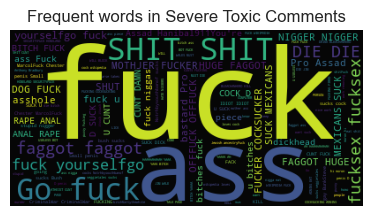

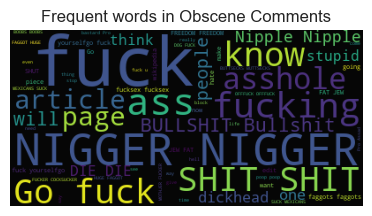

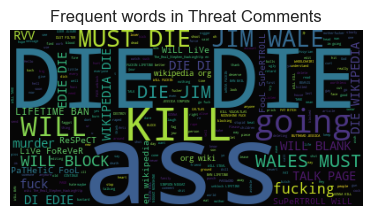

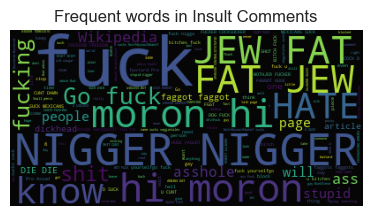

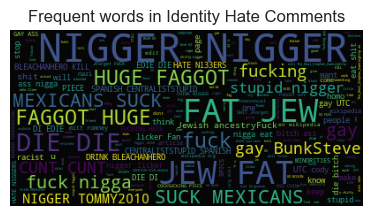

In [11]:
def generate_and_plot_wordcloud(df, column_name, title):
    """
    Generate and display a word cloud based on a subset of comments from a DataFrame.

    Parameters:
    - df (pd.DataFrame): The DataFrame containing the comments.
    - column_name (str): The name of the column indicating the condition for the subset.
    - title (str): The title of the word cloud.

    Returns:
    None

    Example:
    generate_and_plot_wordcloud(df, "toxic", "viridis", "Frequent words in Toxic Comments")
    """
    subset = df[df[column_name] == 1]
    text = subset.comment_text.values

    stopwords = set(STOPWORDS)
    wc = WordCloud(
        background_color="black",
        max_words=2000,
        stopwords=stopwords,
        random_state=17
    )
    wc.generate(" ".join(text))

    plt.figure(figsize=(10, 10))
    plt.subplot(3, 2, i)
    plt.axis("off")
    plt.title(title, fontsize=12)
    plt.imshow(wc, alpha=0.98)

# Define column names and corresponding colour maps
columns = ["toxic", "severe_toxic", "obscene", "threat", "insult", "identity_hate"]
titles = ["Frequent words in Toxic Comments", "Frequent words in Severe Toxic Comments",
          "Frequent words in Obscene Comments", "Frequent words in Threat Comments",
          "Frequent words in Insult Comments", "Frequent words in Identity Hate Comments"]

# Cycle through columns and word cloud generation
for i, column in enumerate(columns, 1):
    generate_and_plot_wordcloud(df, column, titles[i-1]) #because indices in Python start from 0, whereas subplots in plt.subplot start from 1.

plt.show()

<a id="6"> </a>
### 2. Pre-processing

Now, let's move on to the data preprocessing phase. To clean data before performing tokenization, a custom function is created, called `text_preprocessing`, that applies the following steps to the comments:
* **Lowercasing**: The first step is to convert the entire text to lowercase using the `lower()` method. This is done to ensure that all words are in the same case, making it easier for subsequent processing steps and analysis.
* **Regular Expression Cleaning**: A regular expression (regex) is used to remove specific patterns from the text, in particular words containing only one letter or one letter followed or preceded by one or more punctuation characters, tabs, or line breaks.
* **Stopword Removal**: Common English stopwords are removed from the text. Stopwords are words that are frequently used in language but often do not carry significant meaning (e.g., "the", "and", "is"). The stopwords are defined in the `nltk` library. The reason why stop words are critical to many applications is that, if we remove the words that are very commonly used in a given language, we can focus on the important words instead.
* **Stemming**: Finally, stemming is applied to the remaining words in the text. Stemming reduces words to their root or base form. The Snowball Stemmer for English is used to perform stemming.

In [12]:
def stemming(sentence):
    """
    Apply stemming to a sentence.
    This function uses the Snowball Stemmer for English to perform stemming
    on each word in a given sentence. Stemming reduces words to their
    root or base form.

    Parameters:
    -----------
    sentence : str
      The input sentence to be stemmed.

    Returns:
    --------
    str
      The stemmed sentence where each word has been reduced to its root form.

    Example:
    --------
    >>> sentence = "Running quickly in the park"
    >>> stemming(sentence)
    'run quick in the park'
    """
    stemmer = SnowballStemmer("english")
    stem_sentence = ""
    for word in sentence.split():
        stem = stemmer.stem(word)
        stem_sentence += stem
        stem_sentence += " "
    stem_sentence = stem_sentence.strip()
    return stem_sentence


def clean_text(text):
    """
    Clean and preprocess text data.

    This function takes a text input and performs the following cleaning steps:
    1. Converts text to lowercase.
    2. Removes words containing only one letter or one letter followed/preceded by
      one or more punctuation characters, plus tabs and line breaks,
      minus the ' character.
    3. Removes common English stopwords.

    Parameters:
    ----------
    text : str
      The input text to be cleaned.

    Returns:
    -------
    str
      The cleaned and preprocessed text, returned as a
      space-separated string of words.
    """
    swords = set(stopwords.words("english"))
    re_stop_words = re.compile(r"\b(" + "|".join(swords) + r")\b", re.I) #Creates a regular expression (regex)
                                                                         #using Python's re module. This regex looks
                                                                         #for matches of whole words that match stopwords
    regex = r'^[a-z]{1}[!"#$%&()*+,-./:;<=>?@\\^_`{|}~\t\n]*$|'+\
          r'^[!"#$%&()*+,-./:;<=>?@\\^_`{|}~\t\n]*[a-z]{1}$' # aim to filter out words that begin or end with special
                                                             #characters, but retain at least one lower case letter inside.
    text = text.lower()
    text = " ".join(word for word in text.split() if not re.match(regex, word)) #removes words that match the regex
                                                                                #defined above, retaining only those that
                                                                                #contain at least one lower case letter.
    text = " ".join(word for word in text.split() if not re.search(re_stop_words, word)) #remove stopwords using the
                                                                                         #stopwords regular expression.
    text = stemming(text) #application of stemming to the text, reducing words to their roots.
    return text


def text_preprocessing(data, column_name="comment_text"):
    """
    Preprocess text data in a DataFrame column.

    This function takes a pandas DataFrame and preprocesses the text data
    in a specified column by applying the `clean_text` function to each element.

    Parameters:
    ----------
    data : pandas.DataFrame
      The DataFrame containing the text data to be preprocessed.
    column_name : str, optional
      The name of the column containing the text data to be preprocessed.
      Default is "comment_text".

    Returns:
    -------
    pandas.DataFrame
      The DataFrame with the specified column's text data
      preprocessed using the `clean_text` function.
    """
    data[column_name] = data[column_name].apply(clean_text)
    return data

In [13]:
import time

start_time = time.time()
preprocessed_df = text_preprocessing(df)
end_time = time.time()

execution_time = end_time - start_time
print(f"Pre-processing execution time: {execution_time} seconds")

Pre-processing execution time: 201.86536145210266 seconds


Considering the long pre-processing time and to avoid having to process the comments every time, it is decided to save the preprocessed DataFrame to a Parquet file:

In [14]:
preprocessed_df.to_parquet("preprocessed_data.parquet", index=False)

Once this is done, the content of this file can be loaded by simply using the `read_parquet` function:

In [15]:
preprocessed_df = pd.read_parquet("preprocessed_data.parquet")

<a id="7"> </a>
#### 2.1. Train-test-val split

The next step is to split the dataset in train, validation and test set. This is done with the `train_test_val_split` function:

In [16]:
def train_test_val_split(X, y, train_size, val_size, random_state=None):
    """
    Split the input data into training, validation, and test sets.
    This function takes the input data `X` and corresponding labels `y` and
    splits them into training, validation, and test sets based on the specified
    ratios.

    Parameters:
    -----------
    X : array-like
      The input data to be split.
    y : array-like
      The corresponding labels for the input data.
    train_size : float
      The ratio of the data to include in the training set.
    val_size : float
      The ratio of the data to include in the validation set.
    random_state : int or None, optional
      Seed for random number generation. If None, no seed is used.

    Returns:
    --------
    tuple
      A tuple containing the split data in the following order:
      (X_train, X_val, X_test, y_train, y_val, y_test)
    """
    test_size_2 = val_size/train_size
    X_train, X_test, y_train, y_test = \
      train_test_split(X, y, train_size=train_size, random_state=random_state)
    X_train, X_val, y_train, y_val = \
      train_test_split(X_train, y_train, test_size=test_size_2, random_state=random_state)
    return (X_train, X_val, X_test, y_train, y_val, y_test)


X = preprocessed_df["comment_text"].values
y = preprocessed_df.drop(["comment_text","sum_injurious", "clean"], axis=1).values

X_train, X_val, X_test, y_train, y_val, y_test = \
    train_test_val_split(X, y, 0.8, 0.2, random_state=0)

In [17]:
X_train.shape, X_test.shape, X_val.shape

((95742,), (31915,), (31914,))

In [18]:
y_train.shape, y_test.shape, y_val.shape

((95742, 6), (31915, 6), (31914, 6))

<a id="8"> </a>
#### 2.2. Conversion in sequences

Finally, the preprocessed comments are converted into sequences, by means of the `Tokenizer` class and the `pad_sequences` function, to pad the sequences to all have the same length. This is achieved by the custom function `get_sequences`:

In [19]:
def get_sequences(X_train, X_val, X_test, num_words=1000):
    """
    Tokenizes and preprocesses the text sequences in the training, validation, and test sets.

    Parameters:
    - X_train (list): List of training text sequences.
    - X_val (list): List of validation text sequences.
    - X_test (list): List of test text sequences.
    - num_words (int, optional): Maximum number of words to keep in the vocabulary. Defaults to 1000.

    Returns:
    - tuple: A tuple containing padded sequences for training, validation, and test sets,
             vocabulary size, and maximum sequence length.

    Example:
    padded_train, padded_val, padded_test, vocab_size, maxlen = get_sequences(X_train, X_val, X_test, num_words=1500)
    """

    tokenizer = Tokenizer(num_words = num_words)
    tokenizer.fit_on_texts(X_train)
    train_sequences= tokenizer.texts_to_sequences(X_train)
    val_sequences= tokenizer.texts_to_sequences(X_val)
    test_sequences= tokenizer.texts_to_sequences(X_test)
    vocab_size = max(
    [index for sequence in train_sequences for index in sequence]
    )+1
    maxlen = len(max(train_sequences,key=len))
    padded_train_sequences = pad_sequences(train_sequences, maxlen=maxlen)
    padded_val_sequences = pad_sequences(val_sequences, maxlen=maxlen)
    padded_test_sequences = pad_sequences(test_sequences, maxlen=maxlen)
    return (padded_train_sequences,
            padded_val_sequences,
            padded_test_sequences,
            vocab_size,
            maxlen)


padded_train_sequences, padded_val_sequences, padded_test_sequences, vocab_size, maxlen = \
    get_sequences(X_train, X_val, X_test)


In [20]:
padded_train_sequences.shape, padded_val_sequences.shape, padded_test_sequences.shape

((95742, 1250), (31914, 1250), (31915, 1250))

In addition to the three sets of sequences, the function returns the `vocab_size` and `maxlen` variables:
* `vocab_size` is the size of the vocabulary, i.e. maximum integer index + 1, as defined by the documentation of the `Embedding` layer that we will use in the following section. It coincides with `num_words`, namely the maximum number of words to keep based on word frequency that needs to be specified during tokenization. Its default value in `get_sequences` is 1000.
* `maxlen` is the maximum length of train sequences, to which all the sequences are padded.

In [21]:
print (f'Vocab size:{vocab_size}\nmaxlen:{maxlen}')

Vocab size:1000
maxlen:1250


<a id="9"> </a>
### 3. Model building

<a id="10"> </a>
#### 3.1. Choice of the proper metric and defining the early stopping

Since in multilabel classification more than one labels can be the correct output for each input sample, it is decided to use **Hamming Loss** (HL) as metric to evaluate the performance of the model on the validation set. Hamming Loss is defined as the fraction of misclassified labels to the total number of labels. For the binary case:
$$
HL=1-\text{accuracy}
$$
Of course, a lower value of Hamming Loss will indicates a better classifier.

In all the subsequent models, the `EarlyStopping` callback will be used. It provides a safeguard against overfitting by monitoring the validation loss and stopping training if the model's performance on unseen data doesn't improve over a specified number of epochs (defined by the `patience` parameter):

In [22]:
early_stopping = EarlyStopping(monitor='val_loss',
                               patience=4,
                               restore_best_weights=True)

<a id="11"> </a>
#### 3.2. Simple RNN Model

The first model that was built, referred to as `model_RNN`, is constructed as follows:

In [23]:
model_RNN = Sequential()
model_RNN.add(Embedding(input_dim=vocab_size,
                        output_dim=128,
                        input_length=maxlen))
model_RNN.add(Dropout(0.8))
model_RNN.add(SimpleRNN(64, activation='tanh'))
model_RNN.add(Dropout(0.5))
model_RNN.add(Dense(6,activation='sigmoid'))
model_RNN.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 1250, 128)         128000    
                                                                 
 dropout (Dropout)           (None, 1250, 128)         0         
                                                                 
 simple_rnn (SimpleRNN)      (None, 64)                12352     
                                                                 
 dropout_1 (Dropout)         (None, 64)                0         
                                                                 
 dense (Dense)               (None, 6)                 390       
                                                                 
Total params: 140742 (549.77 KB)
Trainable params: 140742 (549.77 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


It is decided to include two **dropout** layers after the embedding layer and before the output layer, since they help prevent **overfitting**, which occurs when a model learns to perform well on the training data but doesn't generalize effectively to new, unseen data.<br> Dropout reduces the likelihood of neurons co-adapting or relying on specific features during training. When dropout is applied, different sets of neurons are active in each forward and backward pass, forcing the network to learn more robust features that work in different combinations. This can lead to a more resilient model that performs better on unseen data.

Let's compile the model, using `binary_crossentropy` as loss function, i.e. without taking into account class imbalance:

In [24]:
model_RNN.compile(loss='binary_crossentropy',
                   optimizer='rmsprop',
                   metrics=[HammingLoss(threshold=0.5, mode='multilabel')])

In [25]:
hist_RNN = model_RNN.fit(padded_train_sequences, y_train,
                         validation_data=(padded_val_sequences, y_val),
                         epochs=8, callbacks=[early_stopping],
                         batch_size=64)

Epoch 1/8
1496/1496 [==============================] - 813s 542ms/step - loss: 0.1455 - hamming_loss: 0.0442 - val_loss: 0.0779 - val_hamming_loss: 0.0227
Epoch 2/8
1496/1496 [==============================] - 802s 536ms/step - loss: 0.0842 - hamming_loss: 0.0252 - val_loss: 0.0792 - val_hamming_loss: 0.0227
Epoch 3/8
1496/1496 [==============================] - 818s 547ms/step - loss: 0.0809 - hamming_loss: 0.0242 - val_loss: 0.0709 - val_hamming_loss: 0.0222
Epoch 4/8
1496/1496 [==============================] - 810s 541ms/step - loss: 0.0796 - hamming_loss: 0.0242 - val_loss: 0.0709 - val_hamming_loss: 0.0219
Epoch 5/8
1496/1496 [==============================] - 821s 549ms/step - loss: 0.0784 - hamming_loss: 0.0236 - val_loss: 0.0700 - val_hamming_loss: 0.0213
Epoch 6/8
1496/1496 [==============================] - 822s 550ms/step - loss: 0.0770 - hamming_loss: 0.0233 - val_loss: 0.0693 - val_hamming_loss: 0.0213
Epoch 7/8
1496/1496 [==============================] - 812s 543ms/step

As for the preprocessed comments, it is decided to save both the model and the history:

In [26]:
if not os.path.exists('models'):
    os.makedirs('models')

model_RNN.save("models/rnn_model.keras")
if not os.path.exists('histories'):
    os.makedirs('histories')
pickle.dump(hist_RNN, open('histories/rnn_history.pkl','wb'))

In [27]:
rnn_model = load_model("models/rnn_model.keras", custom_objects = {'HammingLoss':HammingLoss(threshold=0.5, mode='multilabel')})
rnn_history = pickle.load(open('histories/rnn_history.pkl','rb'))

Let's plot the learning curves of the loss function and the Hamming Loss:

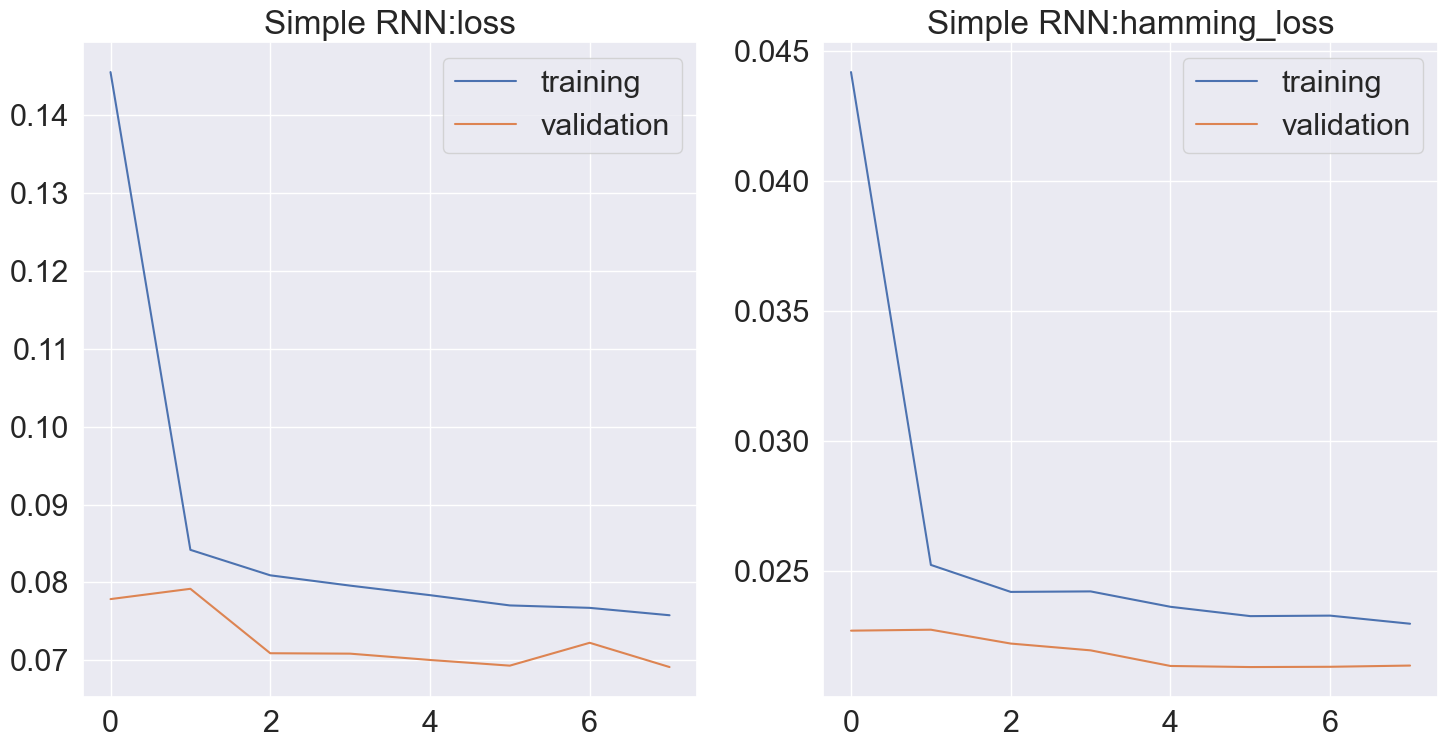

In [28]:
def plot_learning_curves(hist, exp_name):
    """
    Plot the learning curves of a neural network model during training.

    Parameters:
    - hist (History): The history object obtained from the model's training.
    - exp_name (str): A name or description of the experiment for labeling the plots.

    Returns:
    None

    Plots two subplots: one for training and validation loss, and another for
    training and validation Hamming loss over epochs.

    Example usage:
    ```
    model_history = model.fit(X_train, y_train, epochs=10, validation_data=(X_val, y_val))
    plot_learning_curves(model_history, "Experiment 1")
    ```

    Note:
    - Ensure that the model is trained with validation data by passing `validation_data`
      to the `fit` method.
    """
    plt.figure(figsize=(15,8))
    for subplot, curve in enumerate(['loss','hamming_loss']):
        plt.subplot(1,2,subplot+1)
        plt.plot(hist.history[curve],label='training')
        plt.plot(hist.history['val_'+curve],label='validation')
        plt.legend()
        plt.title(exp_name+':'+curve)
    plt.tight_layout()
    plt.show()


plot_learning_curves(rnn_history, 'Simple RNN')

In addition, the following plot shows the multilabel confusion matrices, one for each label:

998/998 [==============================] - 64s 64ms/step


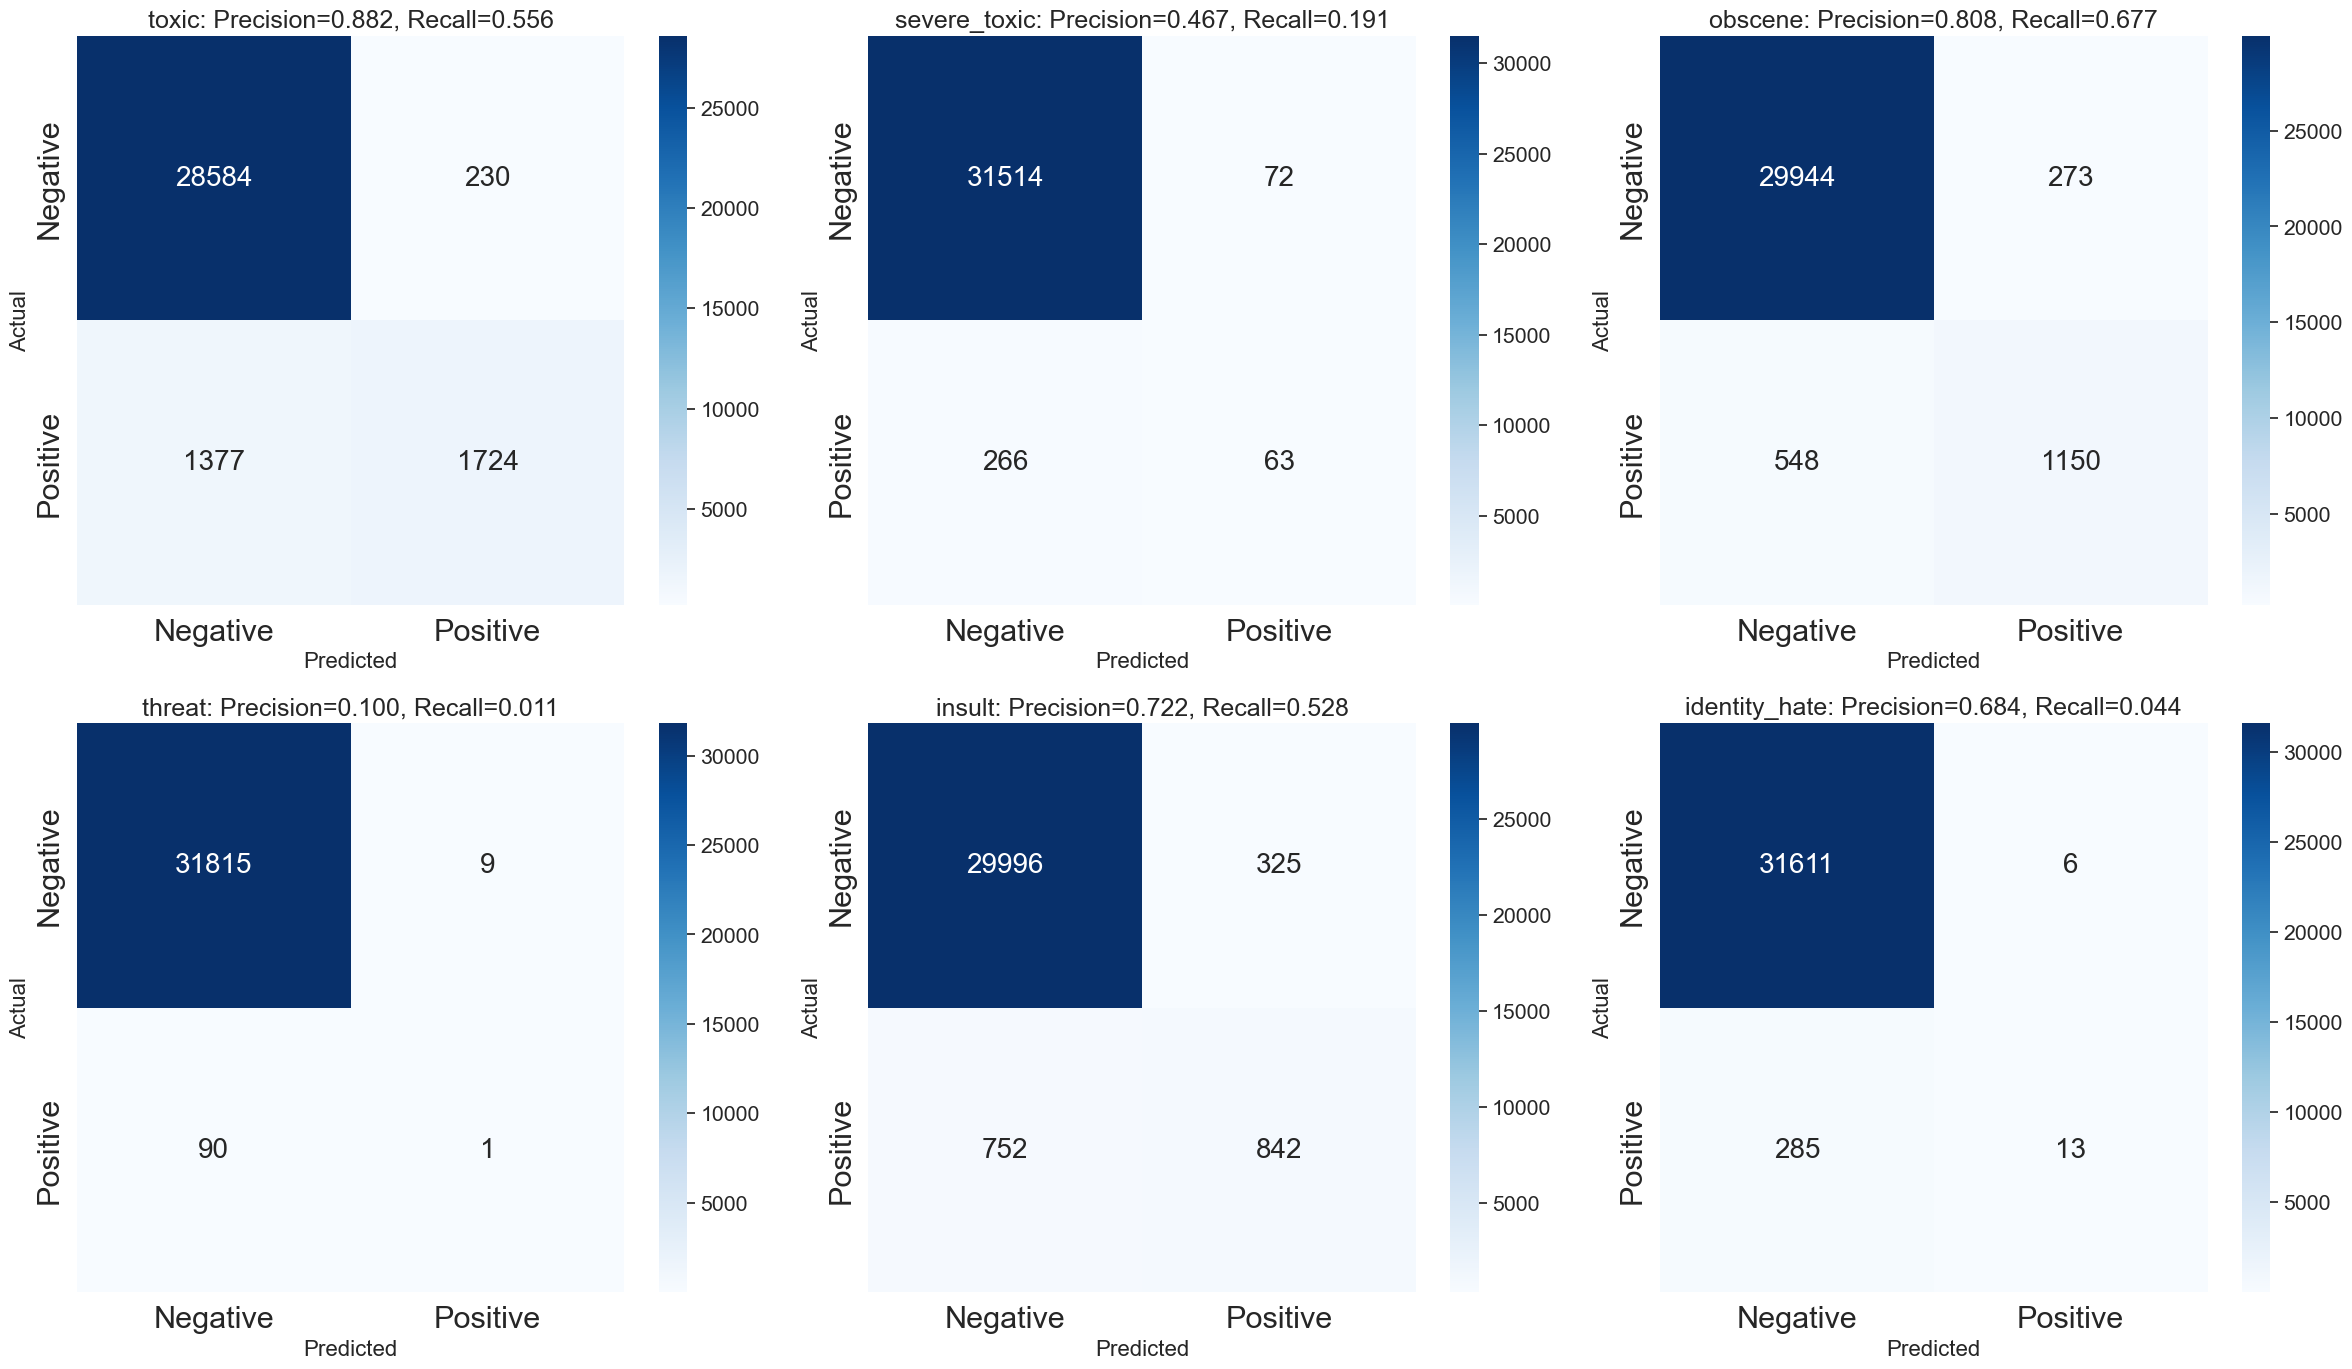

In [29]:
def plot_mcms(model, X, y_true, threshold=.5, labels=None):
    """
    Plot the multilabel confusion matrices for each class in a multilabel classification task.

    Parameters:
    - model (tf.keras.Model): The trained multilabel classification model.
    - X (numpy.ndarray): Input data for prediction.
    - y_true (numpy.ndarray): True labels for evaluation.
    - threshold (float, optional): The probability threshold for classification (default is 0.5).
    - labels (list, optional): List of label names corresponding to each class (default is None).

    Returns:
    None

    Plots a grid of multilabel confusion matrices, each displaying Precision and Recall values
    for the corresponding class.

    Example usage:
    ```
    # Assuming 'model' is a trained multilabel classification model
    plot_mcms(model, X_test, y_test, threshold=0.6, labels=['class_1', 'class_2', 'class_3'])
    ```

    Note:
    - The input model should be a multilabel classification model.
    - The function uses the threshold to convert predicted probabilities to binary predictions.
    - If 'labels' are not provided, default labels will be generated.
    """
    y_pred_proba = model.predict(X)
    y_pred = np.where(y_pred_proba > threshold, 1, 0)
    if labels is not None:
        labels = labels
    else:
        labels = [f"label_{i}" for i in range(1,y_true.shape[1]+1)]
    mcm = multilabel_confusion_matrix(y_true, y_pred)
    fig, axes = plt.subplots(2, 3, figsize=(24, 14))
    for i, ax in enumerate(axes.flat):
        if i<len(labels):
            tn, fp, fn, tp = mcm[i].ravel()
            precision = tp / (tp + fp)
            recall = tp / (tp + fn)
            df_cm = pd.DataFrame(
                mcm[i],
                index=["Negative", "Positive"],
                columns=["Negative", "Positive"]
            )
            sns.set(font_scale=1.4)
            sns.heatmap(df_cm, annot=True, fmt='d', cmap='Blues', ax=ax, annot_kws={"size": 20})
            ax.set_title(f"{labels[i]}: Precision={precision:.3f}, Recall={recall:.3f}", fontsize=18)
            ax.set_xlabel("Predicted", fontsize=16)
            ax.set_ylabel("Actual", fontsize=16)
        else:
            ax.axis('off')
    plt.tight_layout()
    # plt.savefig("nome_del_file.png")
    plt.show()


labels = ["toxic", "severe_toxic", "obscene", "threat", "insult", "identity_hate"]
plot_mcms(rnn_model, padded_test_sequences, y_test, labels=labels)

In [30]:
y_pred_proba = rnn_model.predict(padded_test_sequences)

998/998 [==============================] - 63s 63ms/step


In [31]:
y_pred = (y_pred_proba > 0.5).astype(int)
mcm = multilabel_confusion_matrix(y_test, y_pred)

# Calculate precision and recall for each class
precisions = [precision_score(y_test[:, i], y_pred[:, i]) for i in range(y_test.shape[1])]
recalls = [recall_score(y_test[:, i], y_pred[:, i]) for i in range(y_test.shape[1])]

# Round values to third decimal places
precisions = [round(precision, 3) for precision in precisions]
recalls = [round(recall, 3) for recall in recalls]

# Create DataFrame
data = {
    "Label": labels,
    "rnn_precision": precisions,
    "rnn_recall": recalls
}

df = pd.DataFrame(data)

df

,Label,rnn_precision,rnn_recall
0,toxic,0.882,0.556
1,severe_toxic,0.467,0.191
2,obscene,0.808,0.677
3,threat,0.100,0.011
4,insult,0.722,0.528
5,identity_hate,0.684,0.044


It is concluded that the amount of true positives for each label is very low, especially for `threat`, `identity_hate` and `severe_toxic`, leading to low values of both precision and recall. As a first step to improve the performance of the model, it is decided to change the loss function.<br>
Binary Cross Entropy penalises incorrect predictions with a higher weight, where the cross entropy is highest when the prediction is completely wrong. The goal when training a binary classification model is to minimise this cross entropy, trying to bring the predictions as close as possible to the actual labels.
Weighted cross entropy is a generalisation of binary cross entropy that allows different weights to be assigned to different classes when calculating the loss. This can be useful when classes are unbalanced and one wishes to give more weight to predictions on a less represented class.
In this case, sklearn's compute class weights method can be used.
However this is a multilabel task and we have to calculate the sum of the weighted cross entropies over all observations (N) and all classes (M)

<a id="12"> </a>
#### 3.3. Weighted Simple RNN Model

As said previously, to deal with the class imbalance problem, that leads to very bad values of both precision and recall in the previous model, it is decided to build a custom loss function, namely a **weighted binary cross entropy**, to give more importance to less represented labels while computing the loss function. It is given by:
$$
-\frac{1}{NM}\sum_{i=1}^N\sum_{j=1}^M\left[w_{1,j}y_{ij}\log(p_{ij})+w_{0,j}(1-y_{ij})\log(1-p_{ij})\right]
$$
where:
* $N$ is the number of instances,
* $M$ is the number of classes,
* $y_{ij}$ is the true label of instance $i$ for class $j$,
* $p_{ij}$ is the predicted probability of instance $i$ for class $j$,
* $w_{0,j}$ ($w_{1,j}$) is the vector of the weights for the $0$ ($1$) values of each label.<br>

The formula represents the average of the weighted cross entropies over all observations and all classes. Each term in the summation is the weighted cross entropy for a specific observation and class. The goal when training a model is to minimise this average in order to improve the model's predictions over all classes and all observations.<br>

Therefore, let's define the class weights and the function to compute the weighted binary cross entropy:

In [32]:
# Calculate the number of observations for each label
num_obs_per_label = np.sum(y_train, axis=0)
# Get the total number of samples in the training set
n_samples = len(padded_train_sequences)

# Initialize a list to store class weights for each label
class_weights = []

# Iterate over each label
for i in num_obs_per_label:
    # Calculate weights for class 0 and class 1
    weight_0 = n_samples / (n_samples - i)
    weight_1 = n_samples / i
    # Normalize the weights
    total = weight_0 + weight_1
    class_weights_0 = weight_0 / total
    class_weights_1 = weight_1 / total
    # Append the normalized weights to the list
    class_weights.append([class_weights_0, class_weights_1])

# Calculate the total sum of weights for normalization
total_sum = sum(sum(weight) for weight in zip(*class_weights))
# Normalize the class weights
class_weights = [[weight/total_sum for weight in class_weights_class] for class_weights_class in zip(*class_weights)]

class_weights

[[0.01599959613683998,
  0.0016433052718068698,
  0.008862359257170311,
  0.0005204960553710318,
  0.00824786056972558,
  0.0014396329023138572],
 [0.15066707052982667,
  0.1650233613948598,
  0.15780430740949636,
  0.16614617061129563,
  0.15841880609694106,
  0.1652270337643528]]

In [33]:
@keras.saving.register_keras_serializable()
def get_weighted_binary_crossentropy(class_weights):
    """
    Create a custom weighted binary cross-entropy loss function.

    Parameters:
    class_weights (list or tuple): Weights for class 0 (negative class) and class 1 (positive class).

    Returns:
    function: Weighted binary cross-entropy loss function.
    """
    def weighted_binary_crossentropy(y_true, y_pred):
        """
        Calculate the weighted binary cross-entropy for a multi-label classification problem.

        Parameters:
        y_true: Tensor of actual target values (labels).
        y_pred: Tensor of model predictions.

        Returns:
        tf.Tensor: Weighted binary cross-entropy value.
        """
        epsilon = 1e-15
        y_true, y_pred = tf.cast(y_true, tf.float32), tf.clip_by_value(y_pred, epsilon, 1 - epsilon)
        weights_0, weights_1 = tf.constant(class_weights[0], dtype=tf.float32), tf.constant(class_weights[1], dtype=tf.float32)

        weighted_bce = - (weights_1 * y_true * tf.math.log(y_pred) + weights_0 * (1 - y_true) * tf.math.log(1 - y_pred))
        mean_weighted_bce = tf.reduce_mean(weighted_bce)

        return mean_weighted_bce

    return weighted_binary_crossentropy

In [34]:
model_RNN_weighted = Sequential([
    Embedding(input_dim=vocab_size,
              output_dim=128,
              input_length=maxlen),
    Dropout(0.8),
    SimpleRNN(64, activation='tanh'),
    Dropout(0.5),
    Dense(6,activation='sigmoid')
])
model_RNN_weighted.summary()


Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 1250, 128)         128000    
                                                                 
 dropout_2 (Dropout)         (None, 1250, 128)         0         
                                                                 
 simple_rnn_1 (SimpleRNN)    (None, 64)                12352     
                                                                 
 dropout_3 (Dropout)         (None, 64)                0         
                                                                 
 dense_1 (Dense)             (None, 6)                 390       
                                                                 
Total params: 140742 (549.77 KB)
Trainable params: 140742 (549.77 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [35]:
model_RNN_weighted.compile(loss= get_weighted_binary_crossentropy(class_weights),
                           optimizer='rmsprop',
                           metrics=[HammingLoss(threshold=0.5, mode='multilabel')])

In [36]:

hist_RNN_weighted = model_RNN_weighted.fit(padded_train_sequences, y_train,
                                           validation_data=(padded_val_sequences, y_val),
                                           epochs=8, callbacks=[early_stopping],
                                           batch_size=64)

Epoch 1/8
1496/1496 [==============================] - 818s 546ms/step - loss: 0.0066 - hamming_loss: 0.3476 - val_loss: 0.0045 - val_hamming_loss: 0.2248
Epoch 2/8
1496/1496 [==============================] - 811s 542ms/step - loss: 0.0045 - hamming_loss: 0.1697 - val_loss: 0.0038 - val_hamming_loss: 0.1191
Epoch 3/8
1496/1496 [==============================] - 816s 545ms/step - loss: 0.0041 - hamming_loss: 0.1348 - val_loss: 0.0036 - val_hamming_loss: 0.0959
Epoch 4/8
1496/1496 [==============================] - 818s 547ms/step - loss: 0.0040 - hamming_loss: 0.1274 - val_loss: 0.0035 - val_hamming_loss: 0.1108
Epoch 5/8
1496/1496 [==============================] - 815s 545ms/step - loss: 0.0038 - hamming_loss: 0.1178 - val_loss: 0.0035 - val_hamming_loss: 0.1366
Epoch 6/8
1496/1496 [==============================] - 814s 544ms/step - loss: 0.0038 - hamming_loss: 0.1172 - val_loss: 0.0034 - val_hamming_loss: 0.1005
Epoch 7/8
1496/1496 [==============================] - 819s 548ms/step

In [37]:
model_RNN_weighted.save("models/rnn_model_weighted.keras")
pickle.dump(hist_RNN_weighted, open('histories/weighted_rnn_history.pkl','wb'))

In [38]:
weighted_rnn_model = load_model("models/rnn_model_weighted.keras", custom_objects={"weighted_binary_crossentropy": get_weighted_binary_crossentropy(class_weights),
                                                                                   'HammingLoss':HammingLoss(threshold=0.5, mode='multilabel')})
weighted_rnn_history = pickle.load(open('histories/weighted_rnn_history.pkl','rb'))

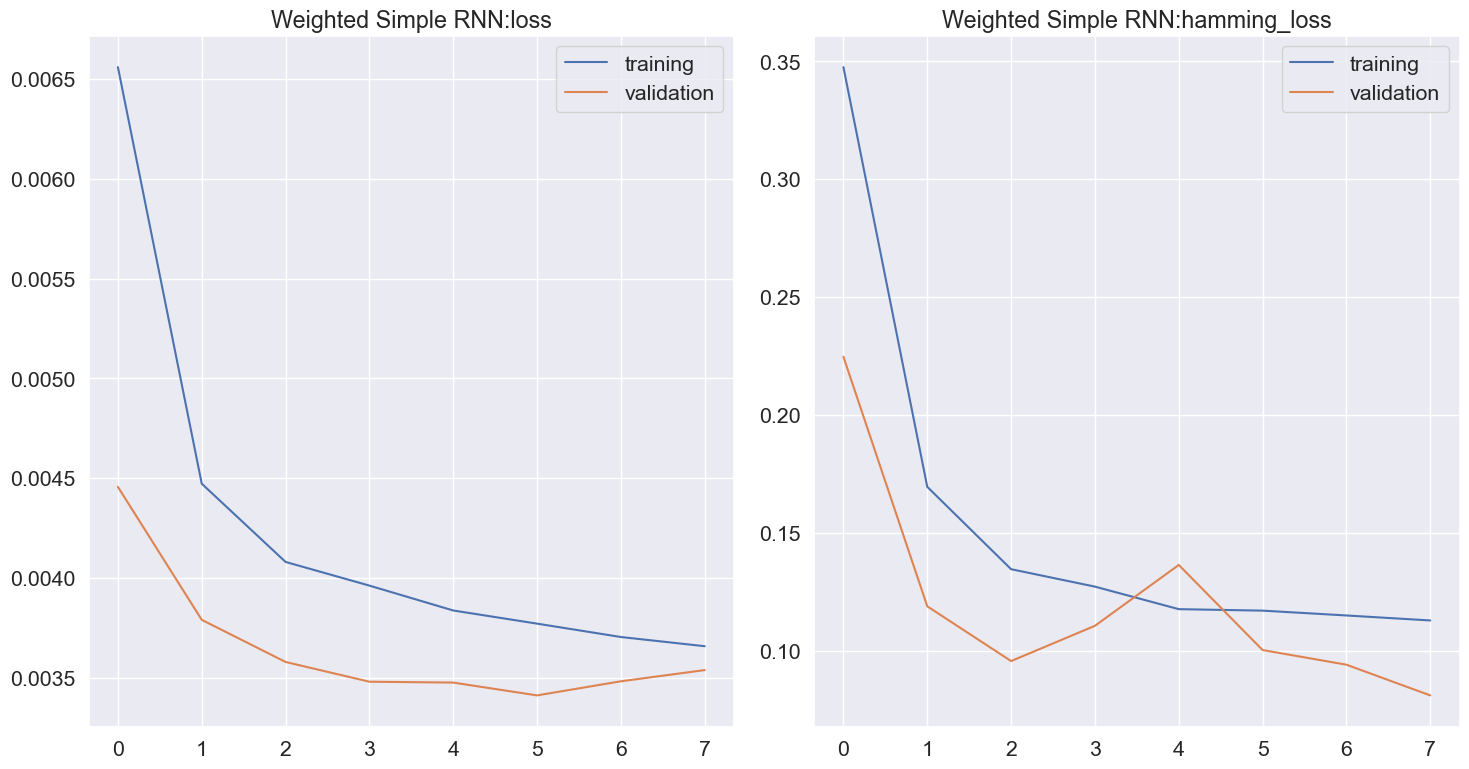

In [39]:
plot_learning_curves(weighted_rnn_history, 'Weighted Simple RNN')

998/998 [==============================] - 61s 61ms/step


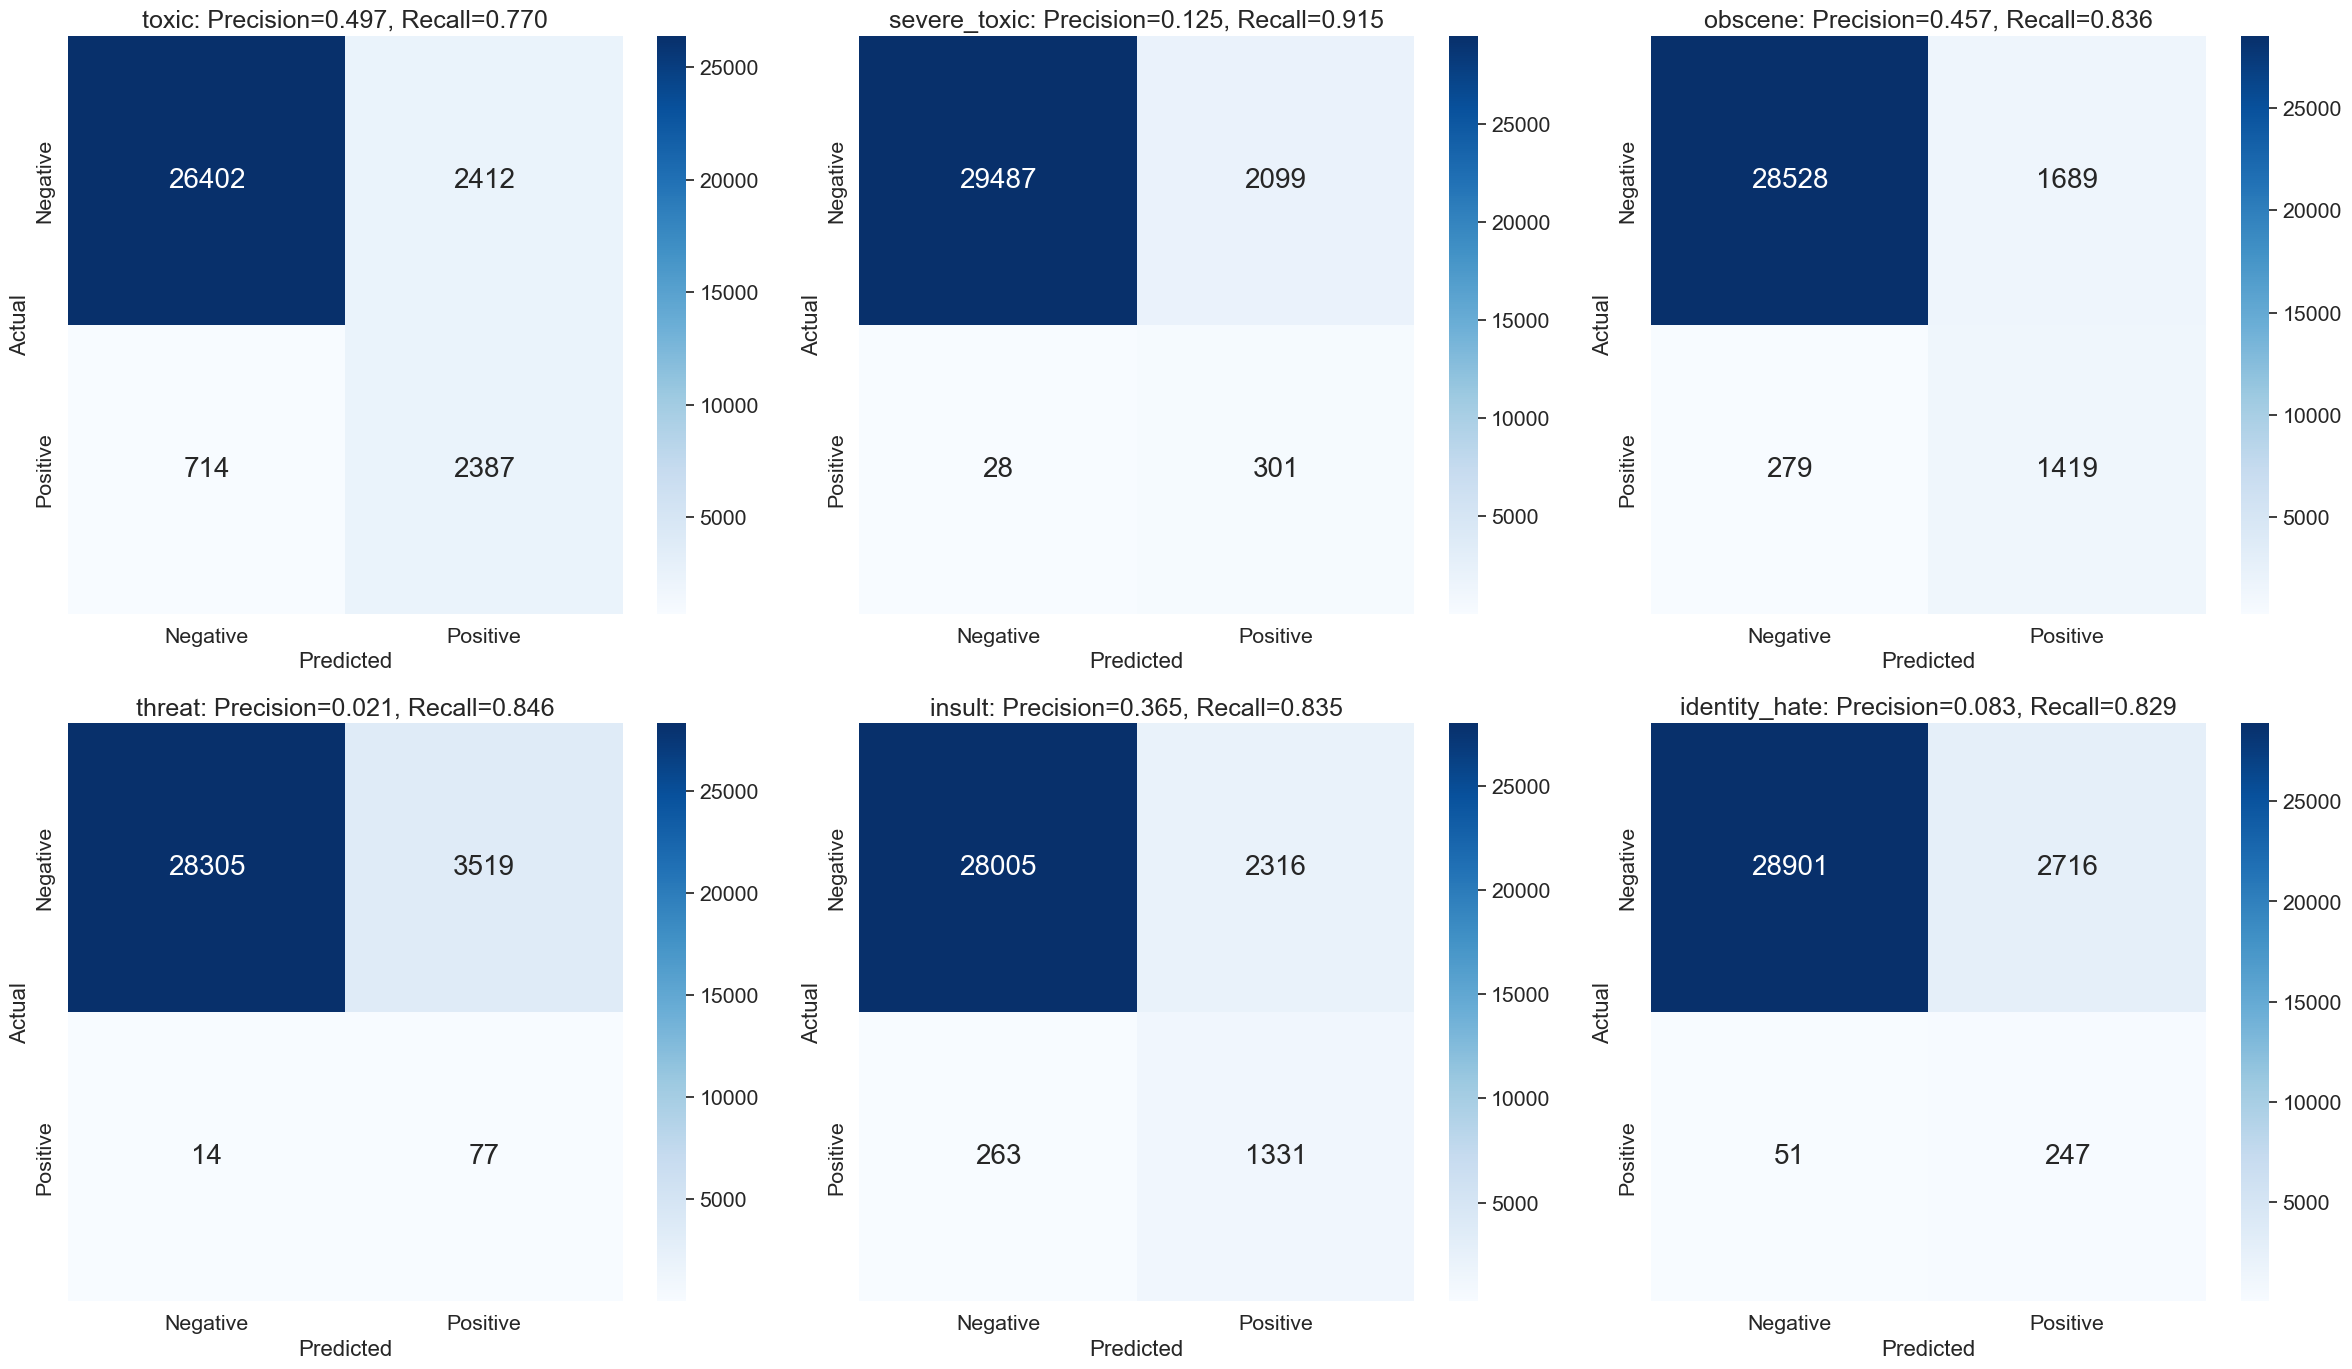

In [40]:
plot_mcms(weighted_rnn_model, padded_test_sequences, y_test, labels=labels)

In [41]:
y_pred_proba = weighted_rnn_model.predict(padded_test_sequences)

998/998 [==============================] - 61s 61ms/step


In [42]:
y_pred = (y_pred_proba > 0.5).astype(int)
mcm = multilabel_confusion_matrix(y_test, y_pred)

# Calculate precision and recall for each class
precisions = [precision_score(y_test[:, i], y_pred[:, i]) for i in range(y_test.shape[1])]
recalls = [recall_score(y_test[:, i], y_pred[:, i]) for i in range(y_test.shape[1])]

# Round values to third decimal places
precisions = [round(precision, 3) for precision in precisions]
recalls = [round(recall, 3) for recall in recalls]

data = {
    "weighted_rnn_precision": precisions,
    "weighted_rnn_recall": recalls
}

df = df.assign(**data)
df

,Label,rnn_precision,rnn_recall,weighted_rnn_precision,weighted_rnn_recall
0,toxic,0.882,0.556,0.497,0.770
1,severe_toxic,0.467,0.191,0.125,0.915
2,obscene,0.808,0.677,0.457,0.836
3,threat,0.100,0.011,0.021,0.846
4,insult,0.722,0.528,0.365,0.835
5,identity_hate,0.684,0.044,0.083,0.829


If compared to the previous model, the number of true positives for each label has increased, resulting in higher recall values but lower precision values, because the number of false positives is also increased (as expected). However, these values are still not satisfactory. As a result, different architectures are being considered in the following models, in which the `SimpleRNN` layer is replaced by a `GRU` layer.

<a id="13"> </a>
#### 3.4.  Long Short-Term Memory (LSTM) and Gated Recurrent Unit (GRU) Model

LSTM (Long Short-Term Memory) and GRU (Gated Recurrent Unit) are two popular types of recurrent neural network (RNN) architectures.

LSTM is a type of RNN architecture that addresses the vanishing gradient problem associated with traditional RNNs. It was introduced to capture long-range dependencies in sequential data. LSTM cells are designed to store and retrieve information over extended time steps.

The key Features of LSTM are:
* **Memory Cells**: LSTMs have memory cells within each unit that can store and update information over time. These memory cells can capture long-term dependencies in the data.
* **Three Gates**: LSTMs have three types of gates that regulate the flow of information:
    1. **Input Gate**: Controls the flow of new information into the cell.
    2. **Forget Gate**: Controls the removal of information from the cell's memory.
    3. **Output Gate**: Controls the information that gets output from the cell.

GRU is another type of RNN architecture that, like LSTM, addresses the vanishing gradient problem. It simplifies the LSTM architecture by combining the cell state and hidden state, making it computationally more efficient than LSTM.

The key Features of GRU are:
* **Simplified Design**: GRU has a simpler design compared to LSTM, with fewer gates. It combines the cell state and hidden state into a single state vector, reducing the number of parameters.
* **Two Gates**: GRU has two gates:
    * **Reset Gate**: Controls which information from the previous state is forgotten.
    * **Update Gate**: Controls the information to be stored in the current state.
* **Efficient Training**: GRUs are computationally more efficient to train compared to LSTMs, and they often require fewer parameters.

Therefore, the main differencs between the two architectures is their complexity: LSTMs have a more complex architecture with three gates (input, forget, output) and separate cell state and hidden state. In contrast, GRUs have a simpler design with only two gates (reset, update) and a single state vector. For this reason, GRUs are computationally more efficient, which makes them faster to train and more suitable for some applications where computational resources are limited.

Therefore, for computational reasons, it is decided to start from a GRU architecture, building models with LSTM layers only if needed.

<a id="14"> </a>
#### 3.5. GRU Model

Let's begin by considering the same model as before, but with the `SimpleRNN` layer replaced by a `GRU` layer (with the same number of units):

In [43]:
model_GRU = Sequential()
model_GRU.add(Embedding(input_dim=vocab_size,
                        output_dim=128,
                        input_length=maxlen))
model_GRU.add(Dropout(0.8))
model_GRU.add(GRU(64,activation='tanh'))
model_GRU.add(Dropout(0.5))
model_GRU.add(Dense(6,activation='sigmoid'))
model_GRU.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_2 (Embedding)     (None, 1250, 128)         128000    
                                                                 
 dropout_4 (Dropout)         (None, 1250, 128)         0         
                                                                 
 gru (GRU)                   (None, 64)                37248     
                                                                 
 dropout_5 (Dropout)         (None, 64)                0         
                                                                 
 dense_2 (Dense)             (None, 6)                 390       
                                                                 
Total params: 165638 (647.02 KB)
Trainable params: 165638 (647.02 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [44]:
model_GRU.compile(loss=get_weighted_binary_crossentropy(class_weights),
                  optimizer='rmsprop',
                  metrics=[HammingLoss(threshold=0.5, mode='multilabel')])

In [45]:
hist_GRU = model_GRU.fit(padded_train_sequences, y_train,
                         validation_data=(padded_val_sequences, y_val),
                         epochs=8, callbacks=[early_stopping],
                         batch_size=64)

Epoch 1/8
1496/1496 [==============================] - 1410s 941ms/step - loss: 0.0076 - hamming_loss: 0.3542 - val_loss: 0.0068 - val_hamming_loss: 0.2633
Epoch 2/8
1496/1496 [==============================] - 1386s 926ms/step - loss: 0.0055 - hamming_loss: 0.2064 - val_loss: 0.0045 - val_hamming_loss: 0.0477
Epoch 3/8
1496/1496 [==============================] - 1424s 952ms/step - loss: 0.0042 - hamming_loss: 0.1278 - val_loss: 0.0037 - val_hamming_loss: 0.1476
Epoch 4/8
1496/1496 [==============================] - 1460s 976ms/step - loss: 0.0039 - hamming_loss: 0.1126 - val_loss: 0.0037 - val_hamming_loss: 0.0591
Epoch 5/8
1496/1496 [==============================] - 1417s 947ms/step - loss: 0.0038 - hamming_loss: 0.1086 - val_loss: 0.0034 - val_hamming_loss: 0.1012
Epoch 6/8
1496/1496 [==============================] - 1421s 950ms/step - loss: 0.0037 - hamming_loss: 0.1070 - val_loss: 0.0034 - val_hamming_loss: 0.1224
Epoch 7/8
1496/1496 [==============================] - 1503s 1s/

In [46]:
model_GRU.save("models/gru_model.keras")
pickle.dump(hist_GRU, open('histories/gru_history.pkl','wb'))

In [47]:
gru_model = load_model("models/gru_model.keras", custom_objects={"weighted_binary_crossentropy": get_weighted_binary_crossentropy(class_weights),
                                                                 'HammingLoss':HammingLoss(threshold=0.5, mode='multilabel')})
gru_history = pickle.load(open('histories/gru_history.pkl','rb'))

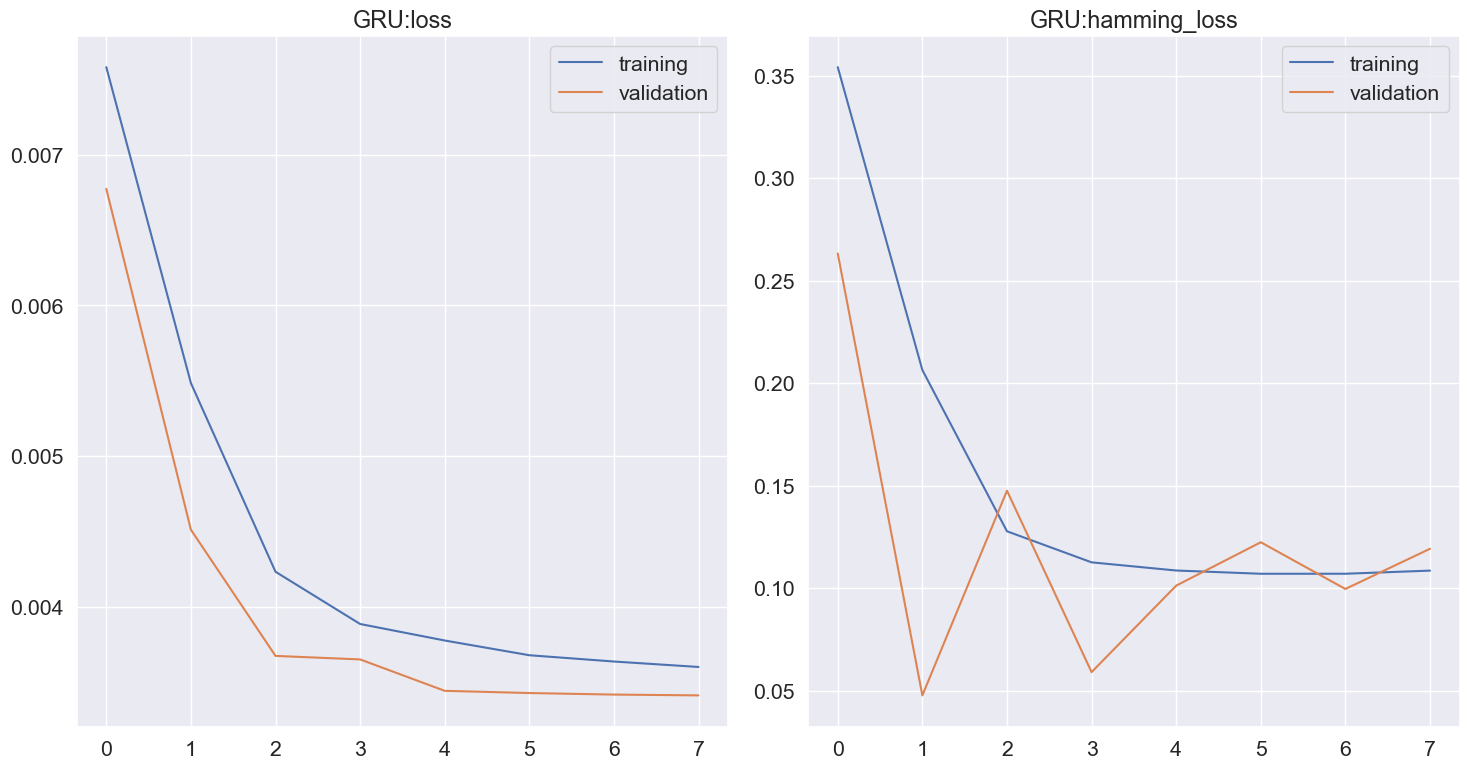

In [48]:
plot_learning_curves(gru_history, 'GRU')

998/998 [==============================] - 144s 144ms/step


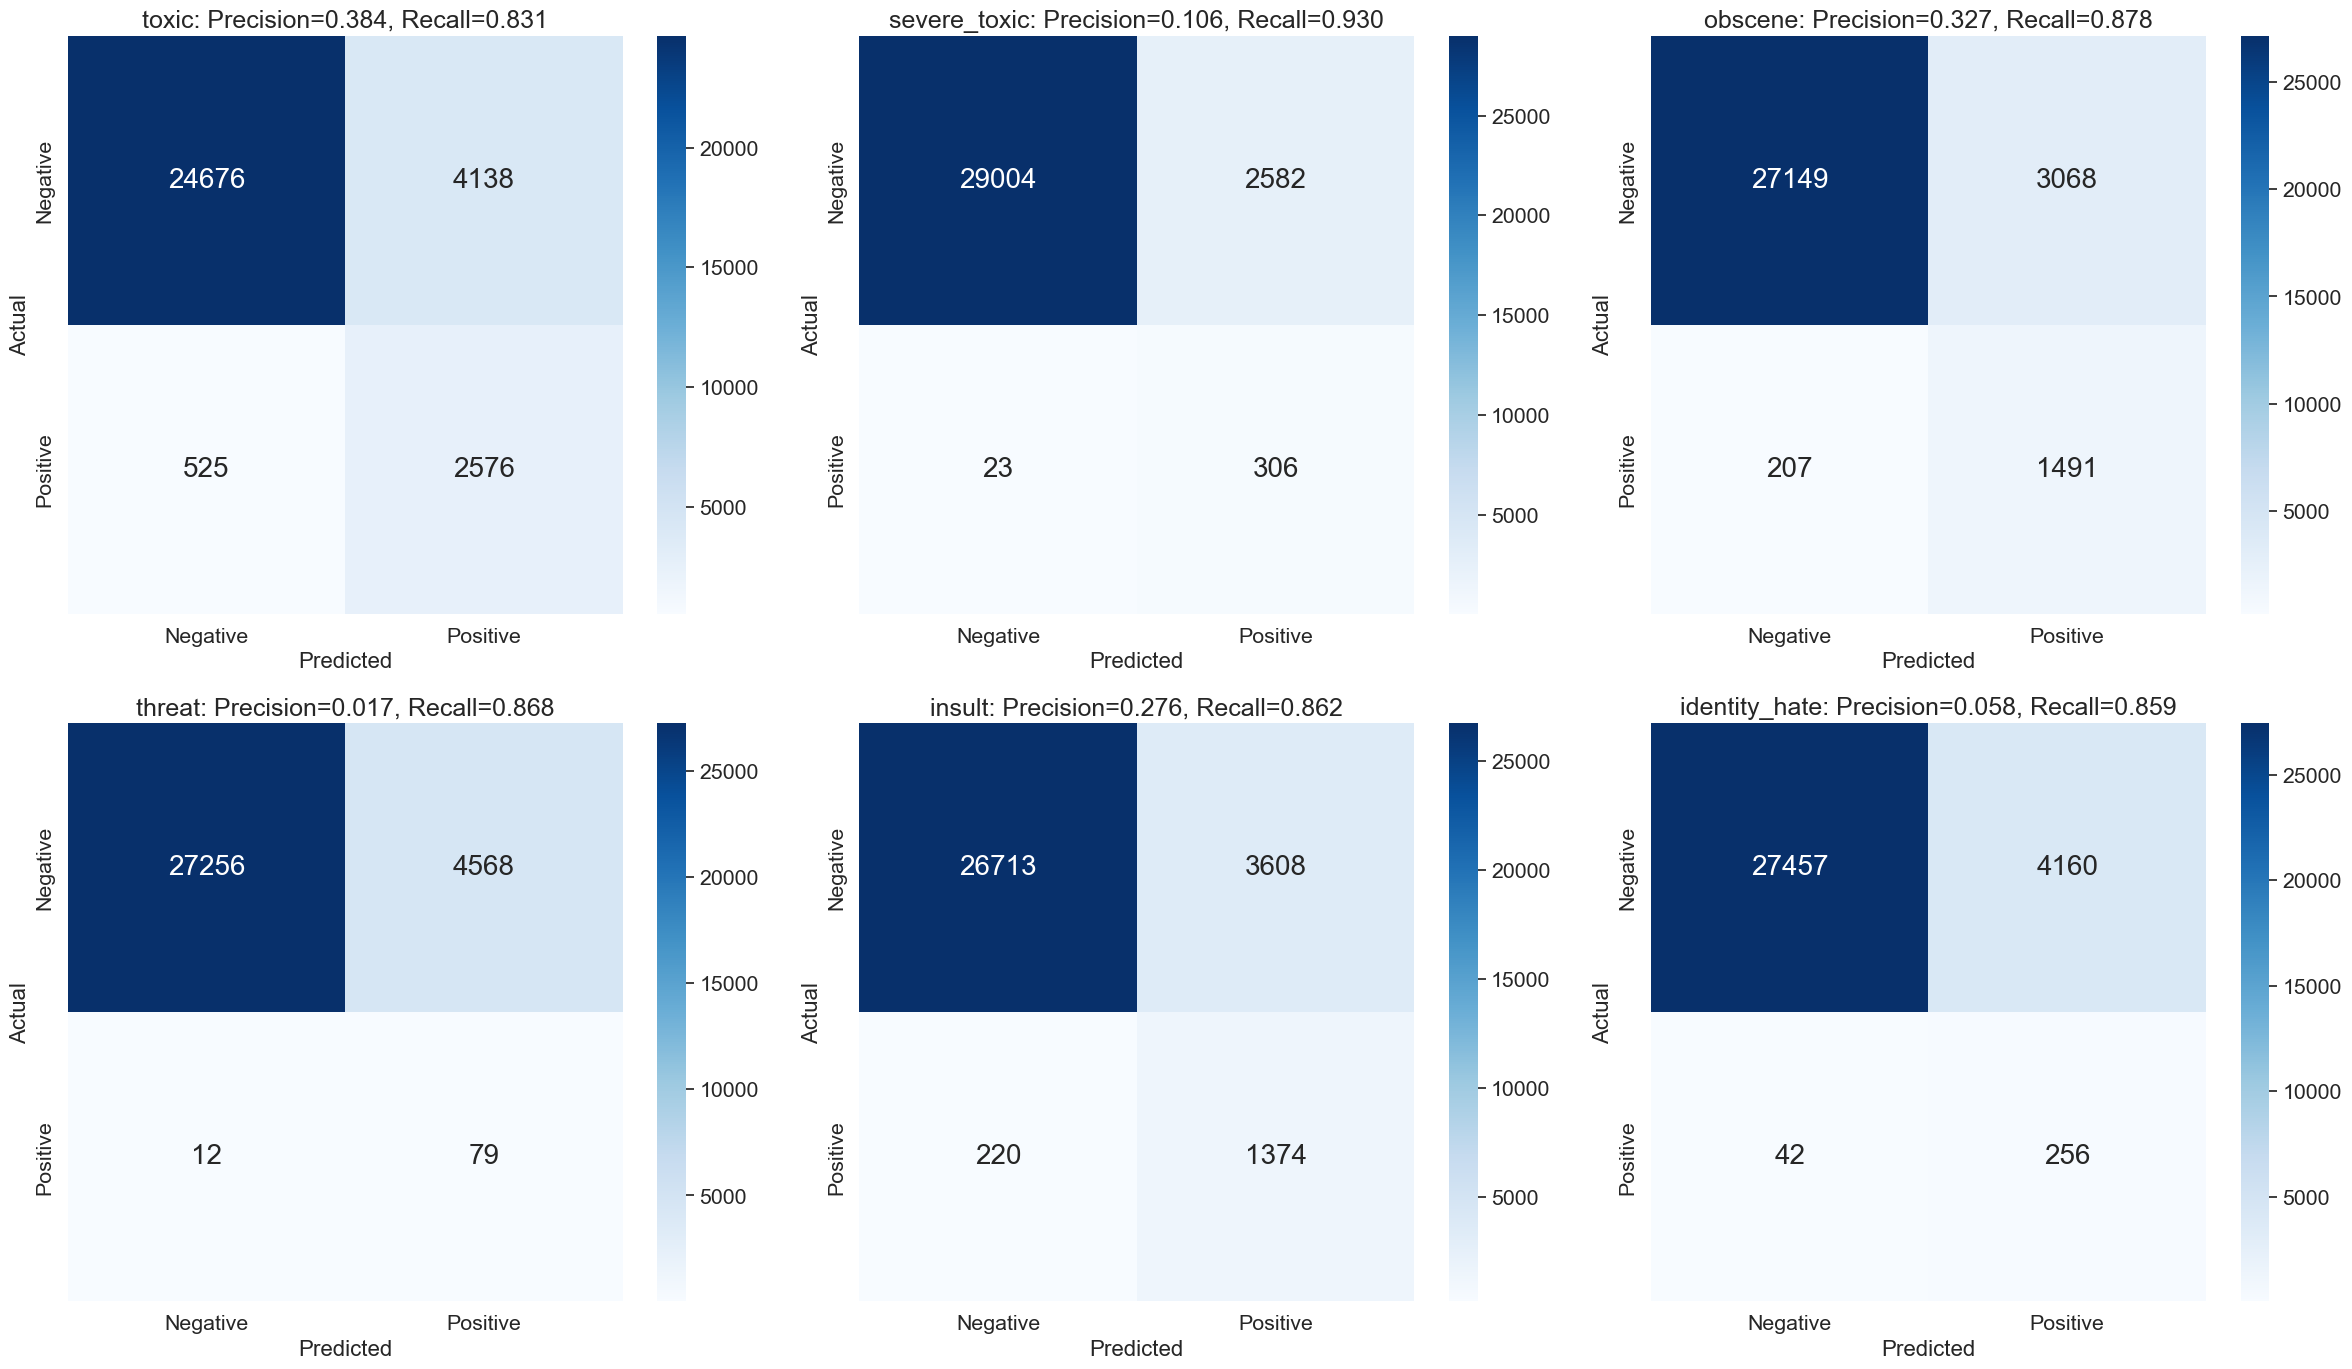

In [49]:
plot_mcms(gru_model, padded_test_sequences, y_test, labels=labels)

In [50]:
y_pred_proba = gru_model.predict(padded_test_sequences)

998/998 [==============================] - 145s 145ms/step


In [51]:
y_pred = (y_pred_proba > 0.5).astype(int)
mcm = multilabel_confusion_matrix(y_test, y_pred)

# Calculate precision and recall for each class
precisions = [precision_score(y_test[:, i], y_pred[:, i]) for i in range(y_test.shape[1])]
recalls = [recall_score(y_test[:, i], y_pred[:, i]) for i in range(y_test.shape[1])]

# Round values to third decimal places
precisions = [round(precision, 3) for precision in precisions]
recalls = [round(recall, 3) for recall in recalls]


data = {
    "gru_precision": precisions,
    "gru_recall": recalls
}

df = df.assign(**data)
df

,Label,rnn_precision,rnn_recall,weighted_rnn_precision,weighted_rnn_recall,gru_precision,gru_recall
0,toxic,0.882,0.556,0.497,0.770,0.384,0.831
1,severe_toxic,0.467,0.191,0.125,0.915,0.106,0.930
2,obscene,0.808,0.677,0.457,0.836,0.327,0.878
3,threat,0.100,0.011,0.021,0.846,0.017,0.868
4,insult,0.722,0.528,0.365,0.835,0.276,0.862
5,identity_hate,0.684,0.044,0.083,0.829,0.058,0.859


<a id="15"> </a>
#### 3.6. Bidirectional GRU Model

Another variant of the previous model involves considering a bidirectional GRU layer instead of a 'normal' GRU layer. This approach may prove beneficial because a bidirectional GRU can capture dependencies in both the past and future directions of the input sequence, providing a more comprehensive understanding of the data. Let's see if this is the case.

In [52]:
model_bidir_GRU = Sequential()
model_bidir_GRU.add(Embedding(input_dim=vocab_size,
                        output_dim=128,
                        input_length=maxlen))
model_bidir_GRU.add(Dropout(0.8))
model_bidir_GRU.add(Bidirectional(GRU(64,activation='tanh')))
model_bidir_GRU.add(Dropout(0.5))
model_bidir_GRU.add(Dense(6,activation='sigmoid'))
model_bidir_GRU.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_3 (Embedding)     (None, 1250, 128)         128000    
                                                                 
 dropout_6 (Dropout)         (None, 1250, 128)         0         
                                                                 
 bidirectional (Bidirection  (None, 128)               74496     
 al)                                                             
                                                                 
 dropout_7 (Dropout)         (None, 128)               0         
                                                                 
 dense_3 (Dense)             (None, 6)                 774       
                                                                 
Total params: 203270 (794.02 KB)
Trainable params: 203270 (794.02 KB)
Non-trainable params: 0 (0.00 Byte)
______________

In [53]:
model_bidir_GRU.compile(loss=get_weighted_binary_crossentropy(class_weights),
                        optimizer='rmsprop',
                        metrics=[HammingLoss(threshold=0.5, mode='multilabel')])

In [54]:
hist_bidir_GRU = model_bidir_GRU.fit(padded_train_sequences, y_train,
                                     validation_data=(padded_val_sequences, y_val),
                                     epochs=8, callbacks=[early_stopping],
                                     batch_size=64)

Epoch 1/8
1496/1496 [==============================] - 2737s 2s/step - loss: 0.0078 - hamming_loss: 0.4494 - val_loss: 0.0074 - val_hamming_loss: 0.2717
Epoch 2/8
1496/1496 [==============================] - 2844s 2s/step - loss: 0.0063 - hamming_loss: 0.2592 - val_loss: 0.0046 - val_hamming_loss: 0.1371
Epoch 3/8
1496/1496 [==============================] - 4857s 3s/step - loss: 0.0045 - hamming_loss: 0.1299 - val_loss: 0.0038 - val_hamming_loss: 0.1601
Epoch 4/8
1496/1496 [==============================] - 2781s 2s/step - loss: 0.0040 - hamming_loss: 0.1092 - val_loss: 0.0036 - val_hamming_loss: 0.0844
Epoch 5/8
1496/1496 [==============================] - 2764s 2s/step - loss: 0.0038 - hamming_loss: 0.1077 - val_loss: 0.0035 - val_hamming_loss: 0.0646
Epoch 6/8
1496/1496 [==============================] - 2748s 2s/step - loss: 0.0037 - hamming_loss: 0.1049 - val_loss: 0.0034 - val_hamming_loss: 0.1151
Epoch 7/8
1496/1496 [==============================] - 2714s 2s/step - loss: 0.003

In [55]:
model_bidir_GRU.save("models/bidir_gru_model.keras")
pickle.dump(hist_bidir_GRU, open('histories/bidir_gru_history.pkl','wb'))

In [56]:
bidir_gru_model = load_model("models/bidir_gru_model.keras", custom_objects={"weighted_binary_crossentropy": get_weighted_binary_crossentropy(class_weights),
                                                                             'HammingLoss':HammingLoss(threshold=0.5, mode='multilabel')})
bidir_gru_history = pickle.load(open('histories/bidir_gru_history.pkl','rb'))

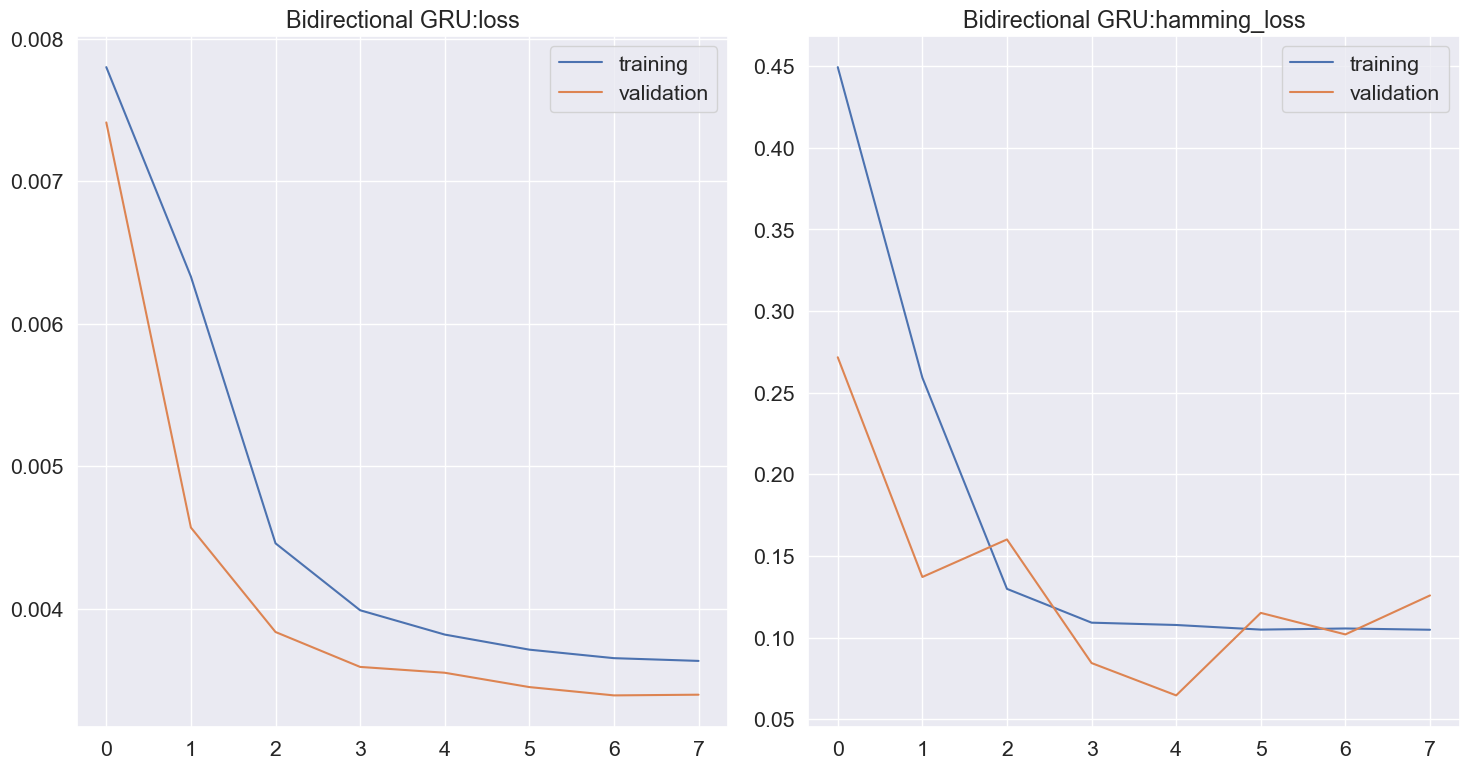

In [57]:
plot_learning_curves(bidir_gru_history, 'Bidirectional GRU')

998/998 [==============================] - 158s 157ms/step


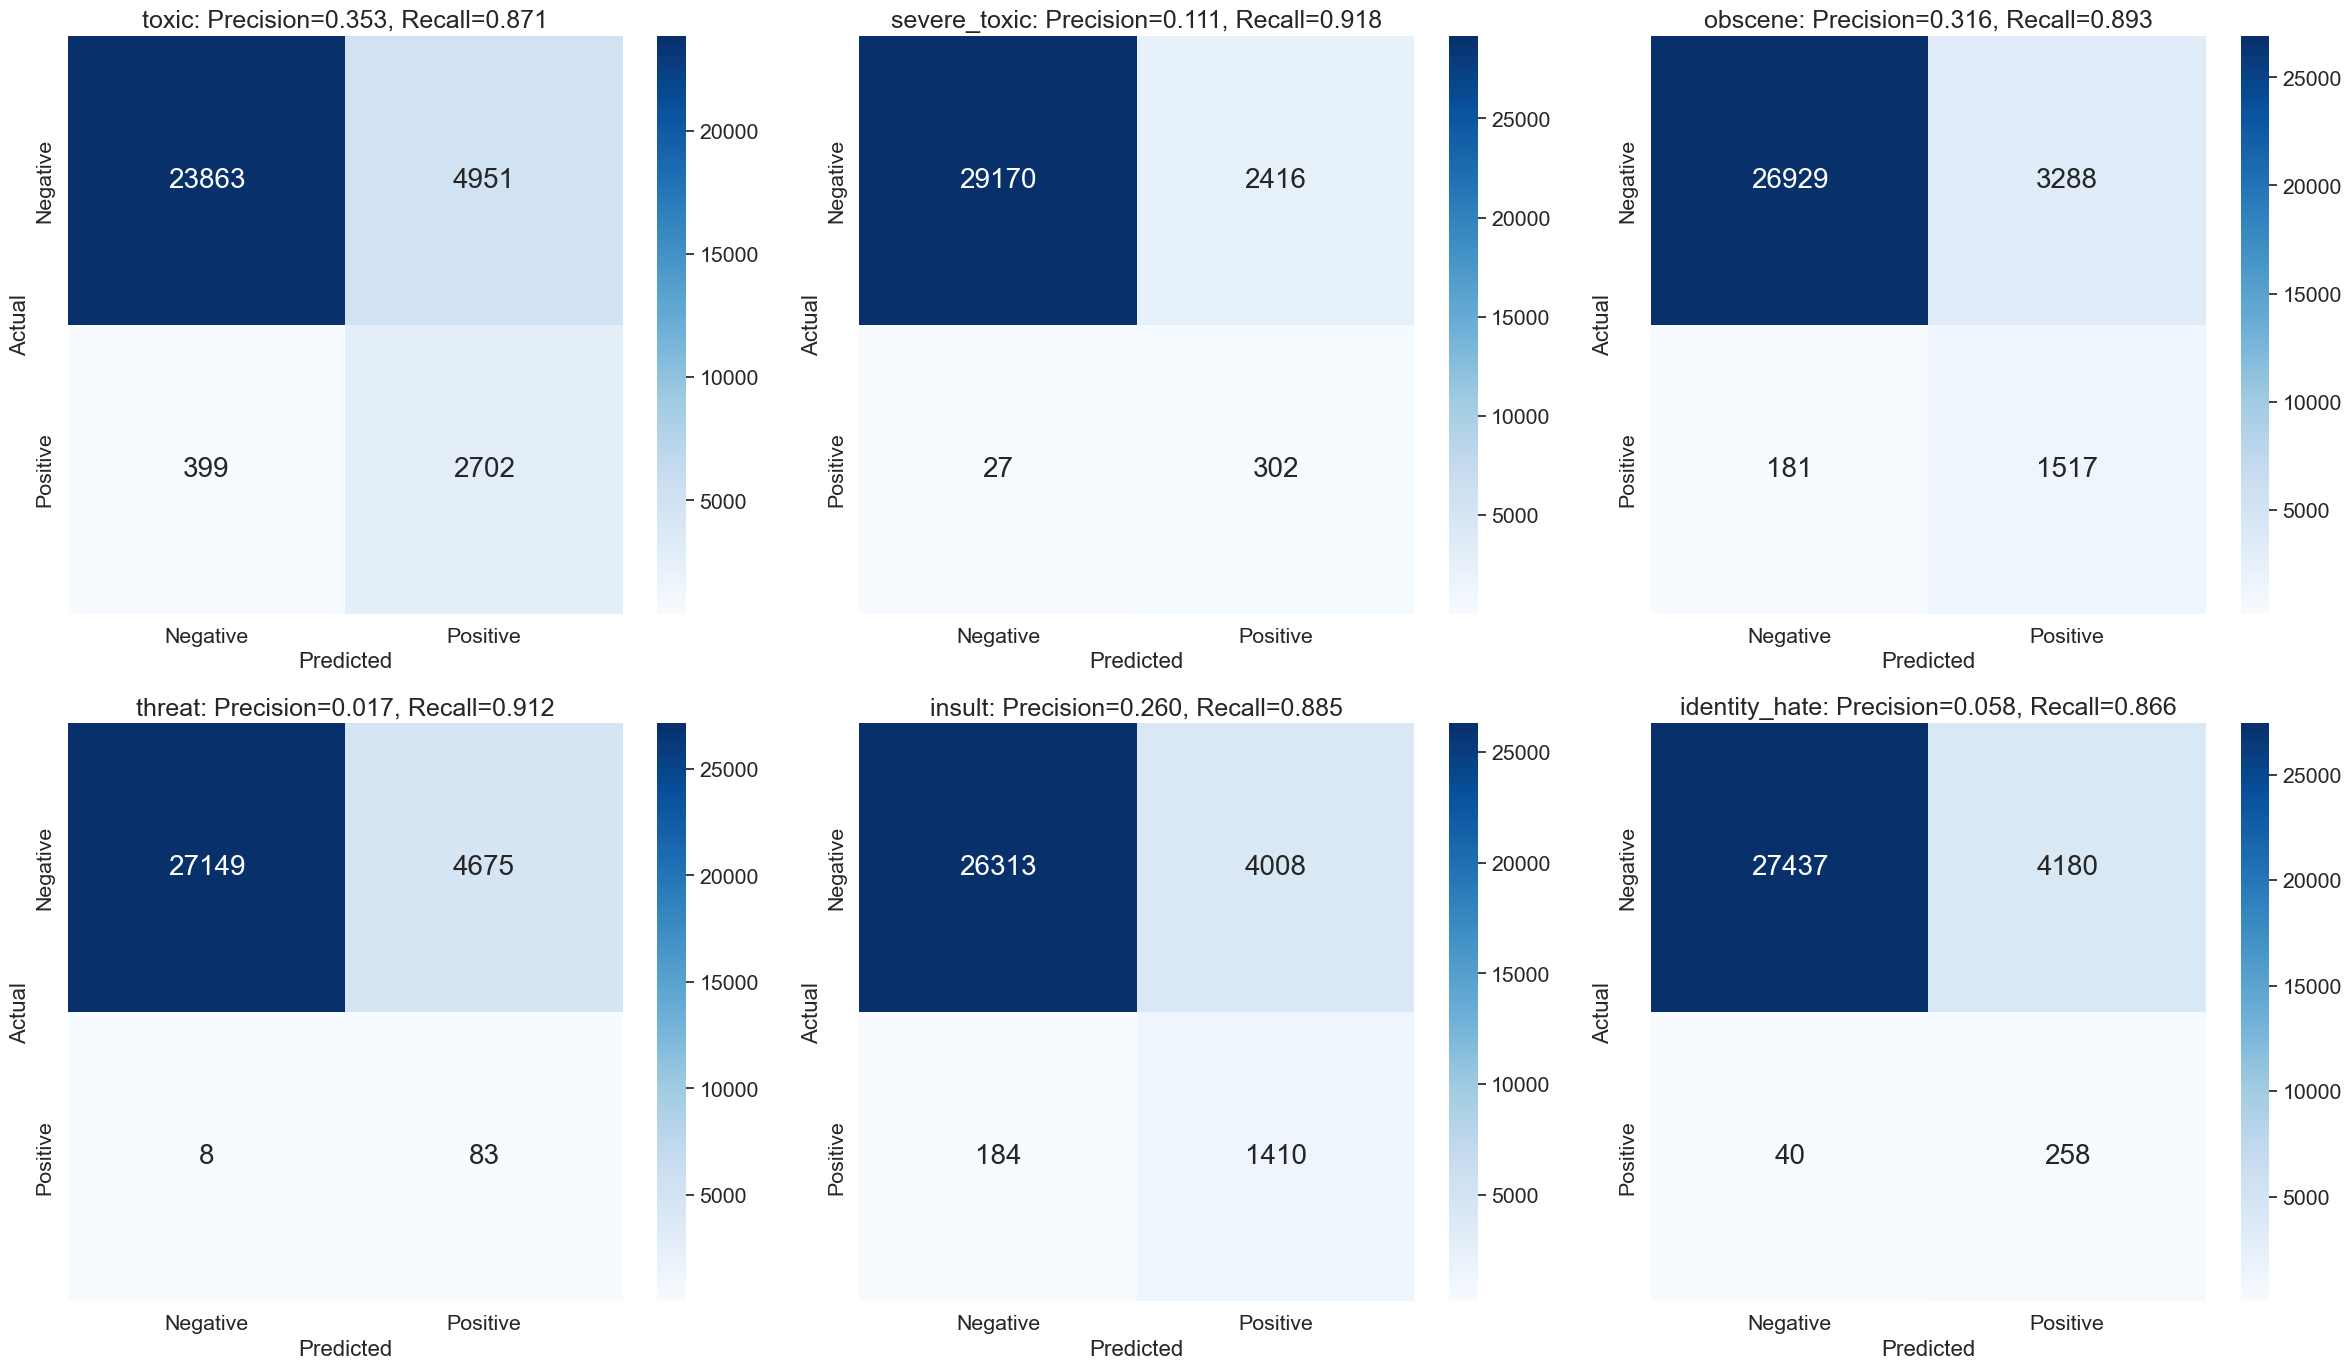

In [58]:
plot_mcms(bidir_gru_model, padded_test_sequences, y_test, labels=labels)

In [59]:
y_pred_proba = bidir_gru_model.predict(padded_test_sequences)

998/998 [==============================] - 158s 158ms/step


In [60]:
y_pred = (y_pred_proba > 0.5).astype(int)
mcm = multilabel_confusion_matrix(y_test, y_pred)

# Calculate precision and recall for each class
precisions = [precision_score(y_test[:, i], y_pred[:, i]) for i in range(y_test.shape[1])]
recalls = [recall_score(y_test[:, i], y_pred[:, i]) for i in range(y_test.shape[1])]

# Round values to third decimal places
precisions = [round(precision, 3) for precision in precisions]
recalls = [round(recall, 3) for recall in recalls]

data = {
    "bidir_gru_precision": precisions,
    "bidir_gru_recall": recalls
}

df = df.assign(**data)
df

,Label,rnn_precision,rnn_recall,weighted_rnn_precision,weighted_rnn_recall,gru_precision,gru_recall,bidir_gru_precision,bidir_gru_recall
0,toxic,0.882,0.556,0.497,0.770,0.384,0.831,0.353,0.871
1,severe_toxic,0.467,0.191,0.125,0.915,0.106,0.930,0.111,0.918
2,obscene,0.808,0.677,0.457,0.836,0.327,0.878,0.316,0.893
3,threat,0.100,0.011,0.021,0.846,0.017,0.868,0.017,0.912
4,insult,0.722,0.528,0.365,0.835,0.276,0.862,0.260,0.885
5,identity_hate,0.684,0.044,0.083,0.829,0.058,0.859,0.058,0.866


Substituting the standard GRU layer with a Bidirectional GRU layer appears to have resulted in a marginal reduction in the architecture's performance. Despite the potential benefits of Bidirectional layers in capturing bidirectional dependencies, it seems that, in this specific context, the improvement is not substantial.

<a id="16"> </a>
#### 3.7. CNN-RNN Hybrid Model

As the model's performance remains unsatisfactory, a decision is made to construct another architecture that better manages the input and output features from the recurrent layer. The new architecture, called `model_CNN_RNN`, incorporates:
* a Convolutional part to potentially improve the model's ability to capture complex patterns in the data;
* an additional Dense layer following the recurrent layer.

In [61]:
model_CNN_RNN = Sequential([
    Embedding(input_dim=vocab_size,output_dim=128,input_length=maxlen),
    Dropout(0.8),
    Conv1D(filters=64, kernel_size=3, padding='same', activation='relu'),
    MaxPooling1D(pool_size=2),
    GRU(64,activation='tanh'),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(6, activation='sigmoid')
])
model_CNN_RNN.compile(loss=get_weighted_binary_crossentropy(class_weights),
                      optimizer='adam',
                      metrics=[HammingLoss(threshold=0.5, mode='multilabel')])
model_CNN_RNN.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_4 (Embedding)     (None, 1250, 128)         128000    
                                                                 
 dropout_8 (Dropout)         (None, 1250, 128)         0         
                                                                 
 conv1d (Conv1D)             (None, 1250, 64)          24640     
                                                                 
 max_pooling1d (MaxPooling1  (None, 625, 64)           0         
 D)                                                              
                                                                 
 gru_2 (GRU)                 (None, 64)                24960     
                                                                 
 dense_4 (Dense)             (None, 128)               8320      
                                                      

The `Conv1D` layer applies 1D convolution to the embedded sequences. This operation extracts local features and patterns from the input data to detect local dependencies or patterns. It is followed by the `MaxPooling1D` layer, which is employed to reduce the spatial dimensions of the data. It selects the maximum values within a window (pool size of 2), capturing the most significant features and reducing computational complexity. Let's fit this model to the train sequences:

In [62]:
hist_CNN_RNN = model_CNN_RNN.fit(padded_train_sequences, y_train,
                                 validation_data=(padded_val_sequences, y_val),
                                 epochs=8, callbacks=[early_stopping],
                                 batch_size=64)

Epoch 1/8
1496/1496 [==============================] - 769s 512ms/step - loss: 0.0040 - hamming_loss: 0.1438 - val_loss: 0.0034 - val_hamming_loss: 0.0843
Epoch 2/8
1496/1496 [==============================] - 775s 518ms/step - loss: 0.0033 - hamming_loss: 0.1202 - val_loss: 0.0034 - val_hamming_loss: 0.0848
Epoch 3/8
1496/1496 [==============================] - 761s 509ms/step - loss: 0.0033 - hamming_loss: 0.1206 - val_loss: 0.0032 - val_hamming_loss: 0.1011
Epoch 4/8
1496/1496 [==============================] - 768s 514ms/step - loss: 0.0032 - hamming_loss: 0.1200 - val_loss: 0.0032 - val_hamming_loss: 0.0948
Epoch 5/8
1496/1496 [==============================] - 773s 517ms/step - loss: 0.0032 - hamming_loss: 0.1212 - val_loss: 0.0035 - val_hamming_loss: 0.0850
Epoch 6/8
1496/1496 [==============================] - 769s 514ms/step - loss: 0.0031 - hamming_loss: 0.1204 - val_loss: 0.0034 - val_hamming_loss: 0.0926
Epoch 7/8
1496/1496 [==============================] - 766s 512ms/step

In [63]:
model_CNN_RNN.save("models/hybrid_model.keras")
pickle.dump(hist_CNN_RNN, open('histories/hybrid_history.pkl','wb'))

In [64]:
hybrid_model = load_model("models/hybrid_model.keras", custom_objects={"weighted_binary_crossentropy": get_weighted_binary_crossentropy(class_weights),
                                                                       'HammingLoss':HammingLoss(threshold=0.5, mode='multilabel')})
hybrid_history = pickle.load(open('histories/hybrid_history.pkl','rb'))

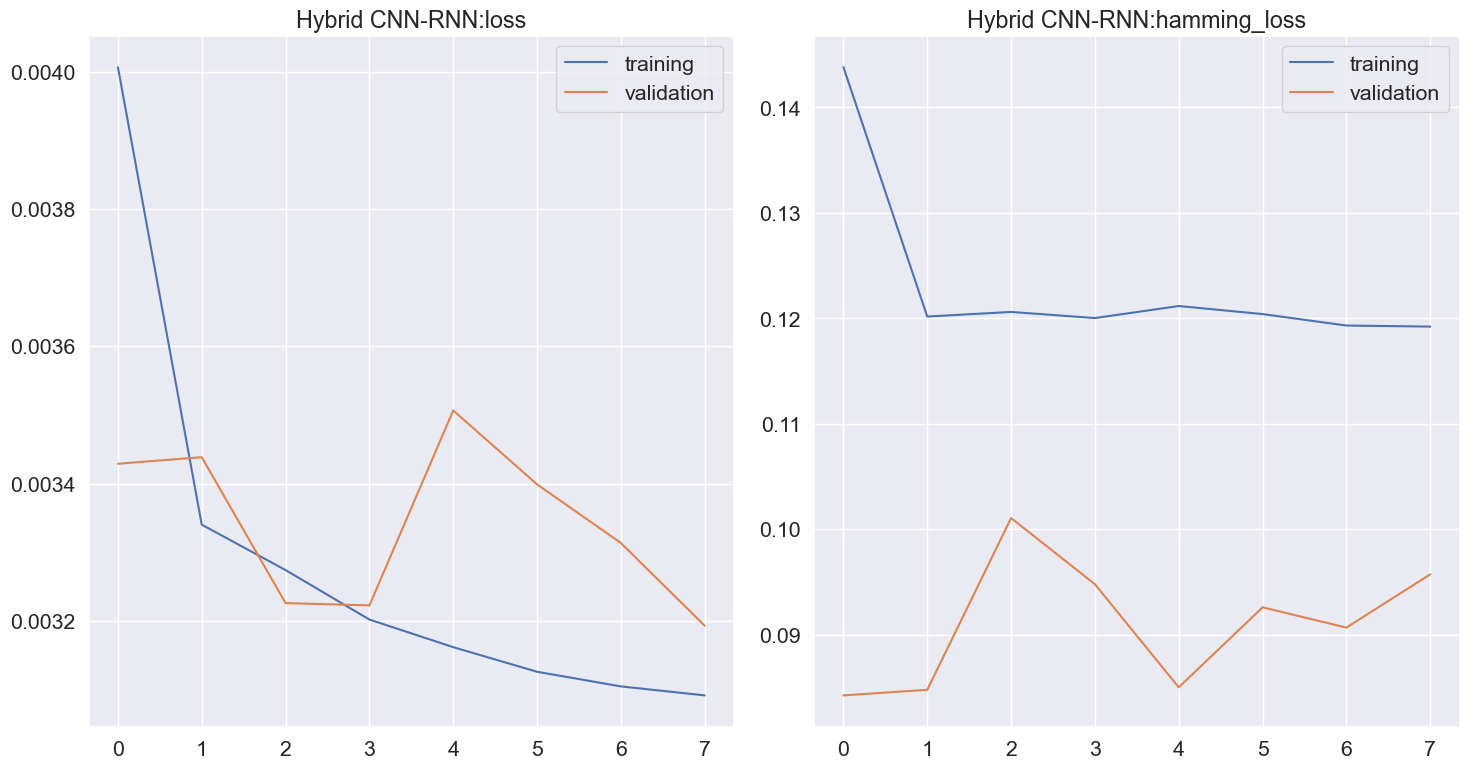

In [65]:
plot_learning_curves(hybrid_history, 'Hybrid CNN-RNN')

998/998 [==============================] - 83s 83ms/step


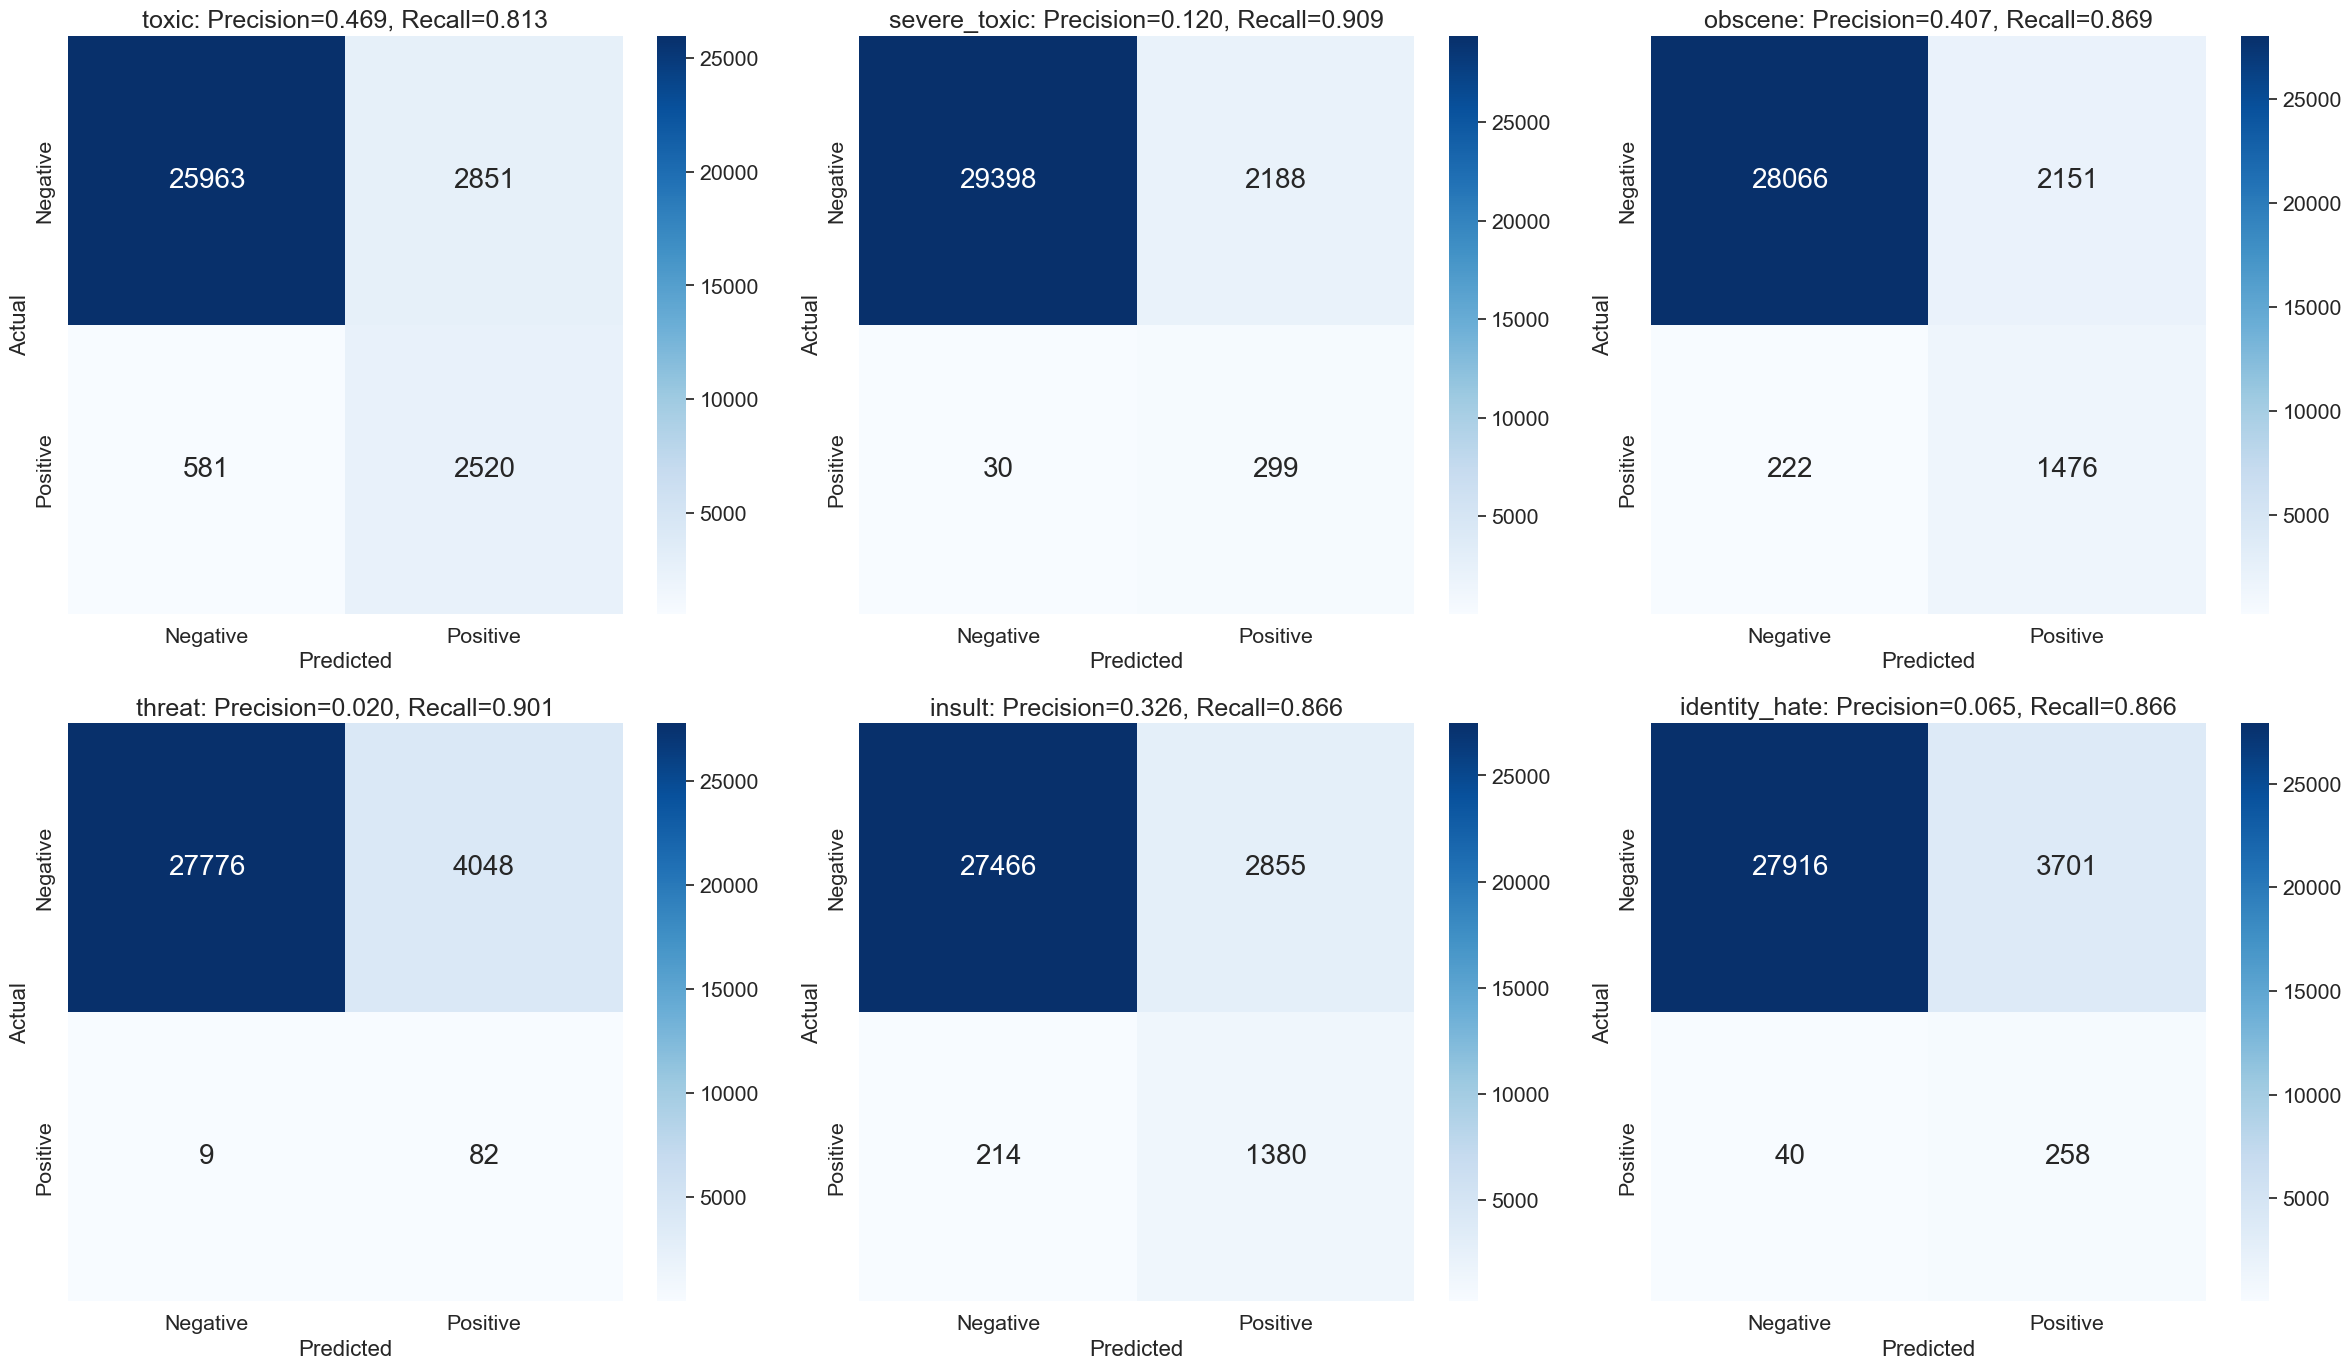

In [66]:
plot_mcms(hybrid_model, padded_test_sequences, y_test, labels=labels)

In [67]:
y_pred_proba = hybrid_model.predict(padded_test_sequences)

998/998 [==============================] - 82s 82ms/step


In [68]:
y_pred = (y_pred_proba > 0.5).astype(int)
mcm = multilabel_confusion_matrix(y_test, y_pred)

# Calculate precision and recall for each class
precisions = [precision_score(y_test[:, i], y_pred[:, i]) for i in range(y_test.shape[1])]
recalls = [recall_score(y_test[:, i], y_pred[:, i]) for i in range(y_test.shape[1])]

# Round values to third decimal places
precisions = [round(precision, 3) for precision in precisions]
recalls = [round(recall, 3) for recall in recalls]


data = {
    "hybrid_precision": precisions,
    "hybrid_recall": recalls
}

df = df.assign(**data)
df

,Label,rnn_precision,rnn_recall,weighted_rnn_precision,weighted_rnn_recall,gru_precision,gru_recall,bidir_gru_precision,bidir_gru_recall,hybrid_precision,hybrid_recall
0,toxic,0.882,0.556,0.497,0.770,0.384,0.831,0.353,0.871,0.469,0.813
1,severe_toxic,0.467,0.191,0.125,0.915,0.106,0.930,0.111,0.918,0.120,0.909
2,obscene,0.808,0.677,0.457,0.836,0.327,0.878,0.316,0.893,0.407,0.869
3,threat,0.100,0.011,0.021,0.846,0.017,0.868,0.017,0.912,0.020,0.901
4,insult,0.722,0.528,0.365,0.835,0.276,0.862,0.260,0.885,0.326,0.866
5,identity_hate,0.684,0.044,0.083,0.829,0.058,0.859,0.058,0.866,0.065,0.866


Although the `val_loss` and `val_hamming_loss` values don't exhibit a significant difference from those of the previous models, this model demonstrates improved precision and recall values for each label. Nevertheless, it's worth noting that the precision values remain relatively low, indicating the presence of a notable number of false positives.

<a id="17"> </a>
### 4.Final Model

As the most recent model has demonstrated superior performance in terms of precision and recall values for each label, it is now a priority to further enhance its capabilities. To achieve this, the following modifications are implemented:
* Increase the `num_words` parameter in the `Tokenizer` from 1000 to 1500.
* Elevate the `output_dim` of the `Embedding` layer from 128 to 256.
* increase the number of `epochs`

These enhancements aim to empower the model by providing it with a more extensive vocabulary and richer feature representations.

In [69]:
padded_train_sequences, padded_val_sequences, padded_test_sequences, vocab_size, maxlen = \
    get_sequences(X_train, X_val, X_test, num_words=1500)

In [70]:
padded_train_sequences.shape, padded_val_sequences.shape, padded_test_sequences.shape

((95742, 1250), (31914, 1250), (31915, 1250))

In [71]:
print (f'Vocab size:{vocab_size}\nmaxlen:{maxlen}')

Vocab size:1500
maxlen:1250


In [72]:
final_model = Sequential([
    Embedding(input_dim=vocab_size,output_dim=256,input_length=maxlen),
    Dropout(0.8),
    Conv1D(filters=64, kernel_size=3, padding='same', activation='relu'),
    MaxPooling1D(pool_size=2),
    GRU(64,activation='tanh'),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(6, activation='sigmoid')
])
final_model.compile(loss=get_weighted_binary_crossentropy(class_weights),
                    optimizer='adam',
                    metrics=[HammingLoss(threshold=0.5, mode='multilabel')])
final_model.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_5 (Embedding)     (None, 1250, 256)         384000    
                                                                 
 dropout_10 (Dropout)        (None, 1250, 256)         0         
                                                                 
 conv1d_1 (Conv1D)           (None, 1250, 64)          49216     
                                                                 
 max_pooling1d_1 (MaxPoolin  (None, 625, 64)           0         
 g1D)                                                            
                                                                 
 gru_3 (GRU)                 (None, 64)                24960     
                                                                 
 dense_6 (Dense)             (None, 128)               8320      
                                                      

In [73]:
final_hist = final_model.fit(padded_train_sequences, y_train,
                             validation_data=(padded_val_sequences, y_val),
                             epochs=20, callbacks=[early_stopping],
                             batch_size=64)

Epoch 1/20
1496/1496 [==============================] - 943s 629ms/step - loss: 0.0037 - hamming_loss: 0.1413 - val_loss: 0.0030 - val_hamming_loss: 0.0759
Epoch 2/20
1496/1496 [==============================] - 949s 635ms/step - loss: 0.0030 - hamming_loss: 0.1069 - val_loss: 0.0031 - val_hamming_loss: 0.0730
Epoch 3/20
1496/1496 [==============================] - 945s 632ms/step - loss: 0.0028 - hamming_loss: 0.1064 - val_loss: 0.0030 - val_hamming_loss: 0.0809
Epoch 4/20
1496/1496 [==============================] - 946s 632ms/step - loss: 0.0028 - hamming_loss: 0.1054 - val_loss: 0.0031 - val_hamming_loss: 0.0783
Epoch 5/20
1496/1496 [==============================] - 942s 630ms/step - loss: 0.0027 - hamming_loss: 0.1047 - val_loss: 0.0029 - val_hamming_loss: 0.0919
Epoch 6/20
1496/1496 [==============================] - 937s 626ms/step - loss: 0.0027 - hamming_loss: 0.1050 - val_loss: 0.0031 - val_hamming_loss: 0.0796
Epoch 7/20
1496/1496 [==============================] - 937s 626

In [74]:
final_model.save("models/final_model.keras")
pickle.dump(final_hist, open('histories/final_history.pkl','wb'))

In [75]:
loaded_model = load_model("models/final_model.keras", custom_objects={"weighted_binary_crossentropy": get_weighted_binary_crossentropy(class_weights),
                                                                      'HammingLoss':HammingLoss(threshold=0.5, mode='multilabel')})
loaded_history = pickle.load(open('histories/final_history.pkl','rb'))

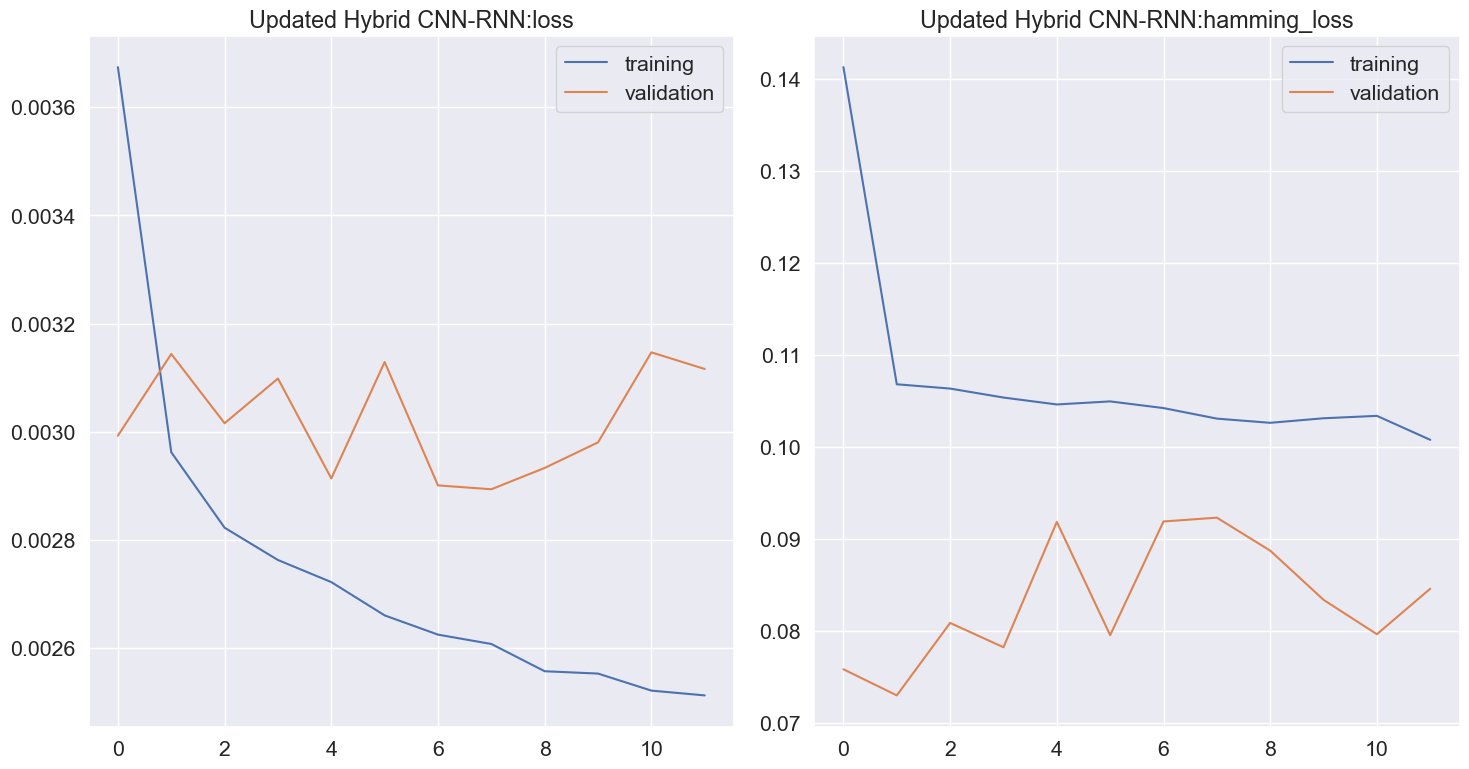

In [76]:
plot_learning_curves(loaded_history, 'Updated Hybrid CNN-RNN')

998/998 [==============================] - 94s 93ms/step


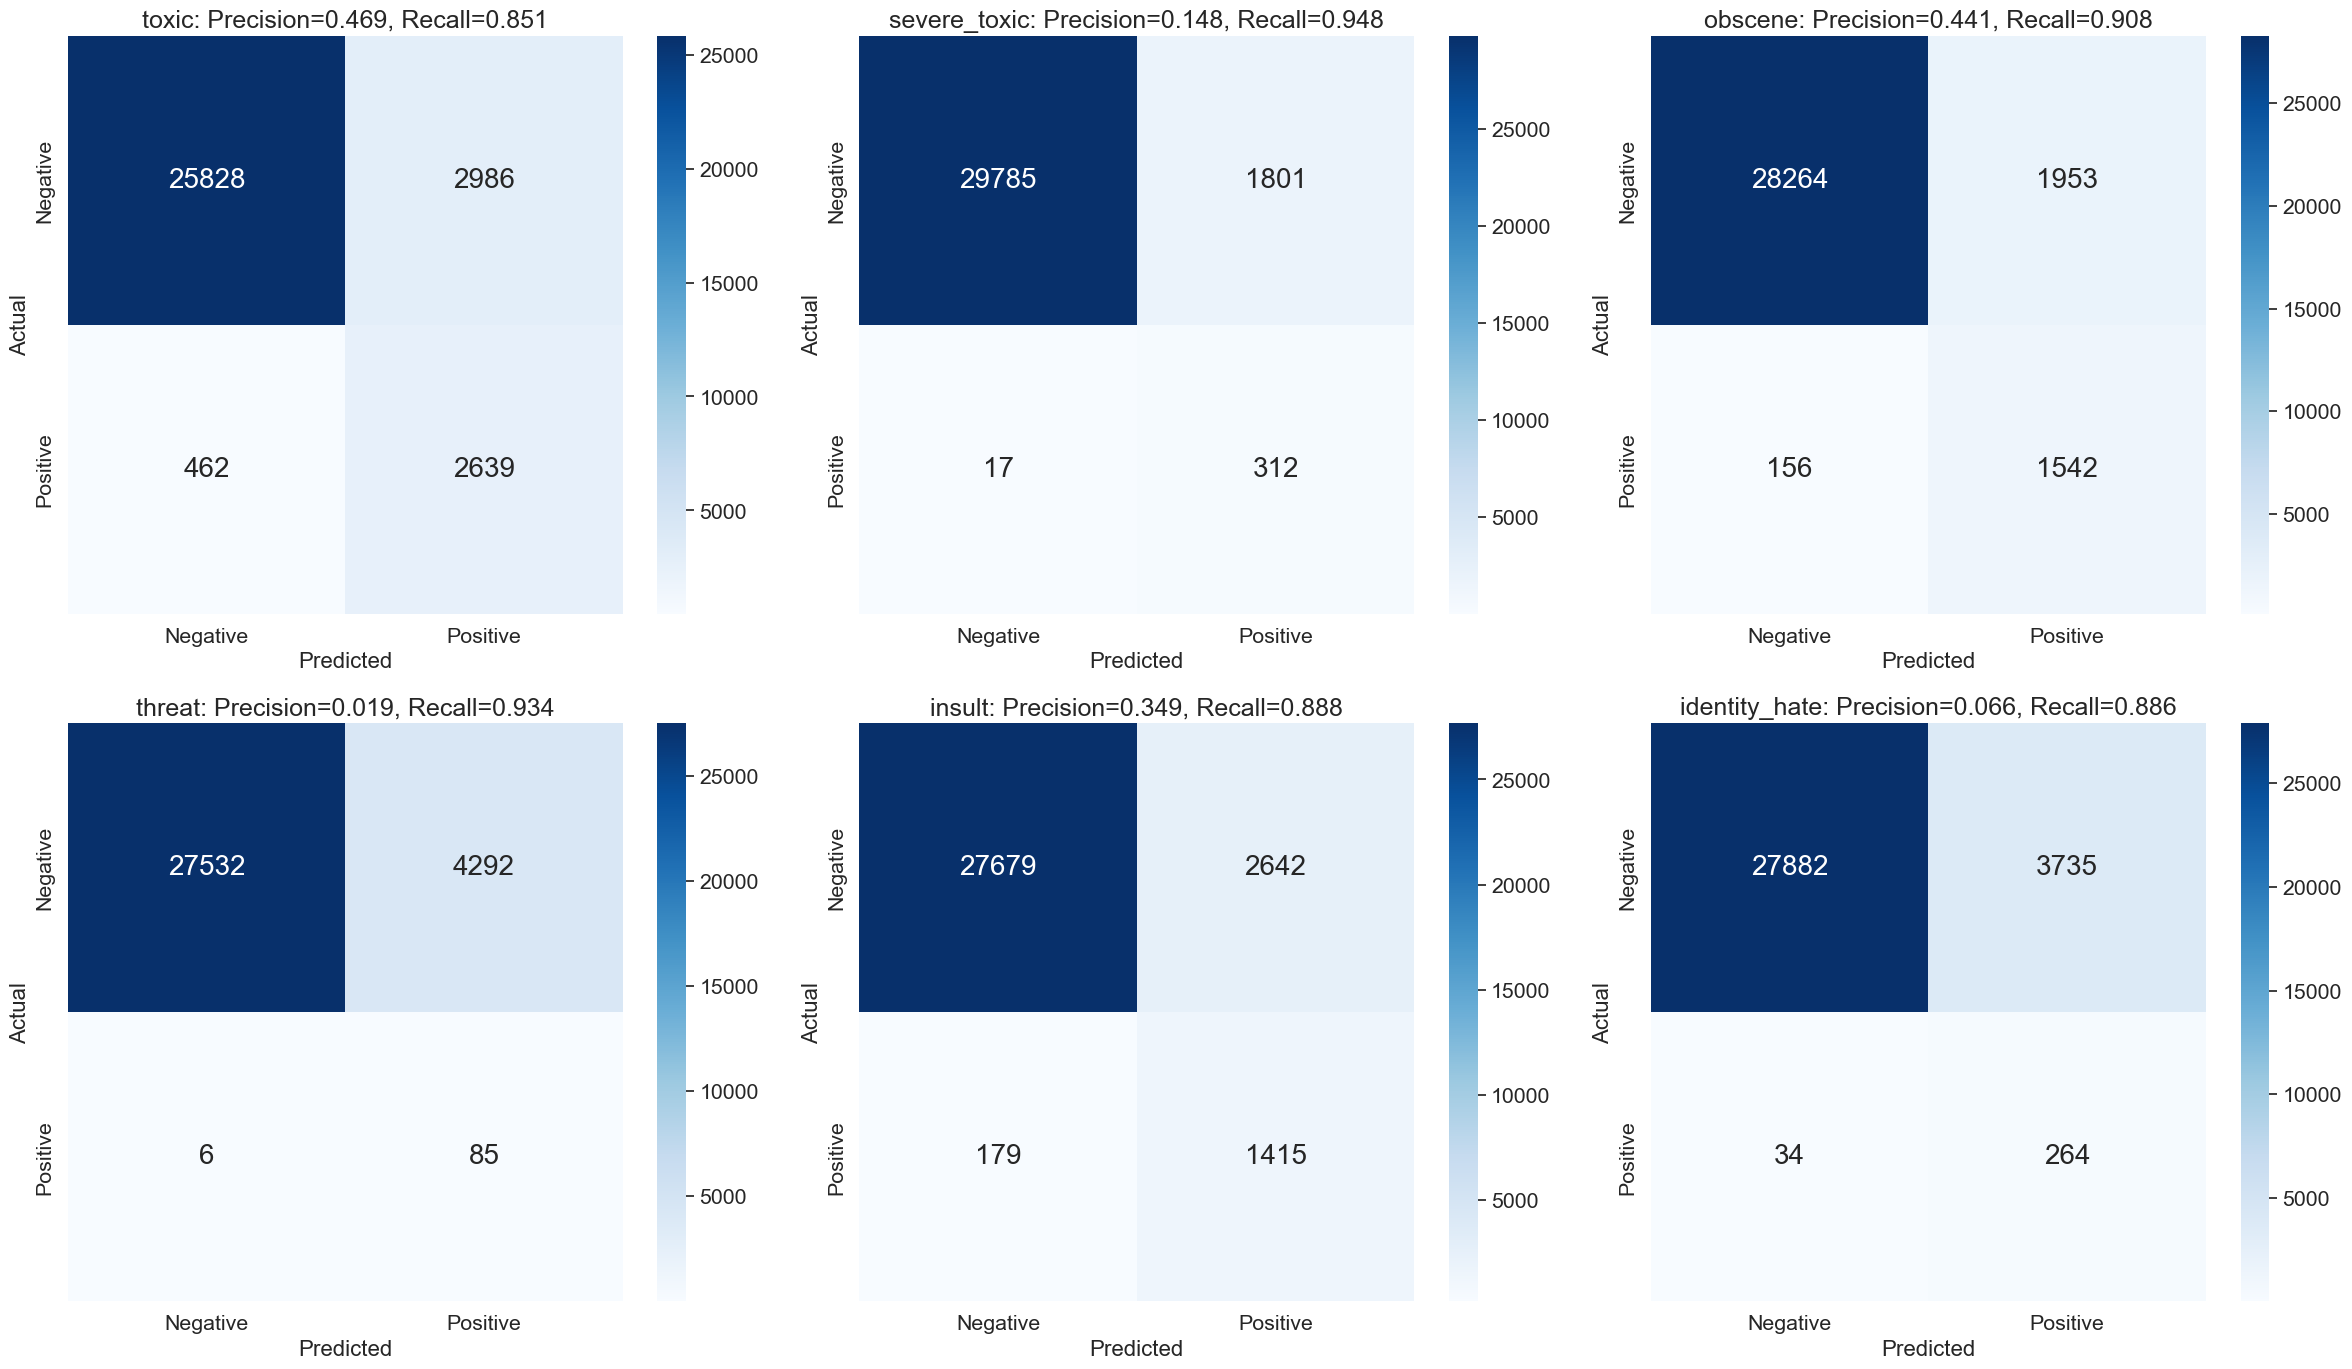

In [77]:
plot_mcms(loaded_model, padded_test_sequences, y_test, labels=labels)

In [78]:
y_pred_proba = loaded_model.predict(padded_test_sequences)

998/998 [==============================] - 95s 95ms/step


In [79]:
y_pred = (y_pred_proba > 0.5).astype(int)
mcm = multilabel_confusion_matrix(y_test, y_pred)

# Calculate precision and recall for each class
precisions = [precision_score(y_test[:, i], y_pred[:, i]) for i in range(y_test.shape[1])]
recalls = [recall_score(y_test[:, i], y_pred[:, i]) for i in range(y_test.shape[1])]

# Round values to third decimal places
precisions = [round(precision, 3) for precision in precisions]
recalls = [round(recall, 3) for recall in recalls]


data = {
    "final_precision": precisions,
    "final_recall": recalls
}

df = df.assign(**data)
df

,Label,rnn_precision,rnn_recall,weighted_rnn_precision,weighted_rnn_recall,gru_precision,gru_recall,bidir_gru_precision,bidir_gru_recall,hybrid_precision,hybrid_recall,final_precision,final_recall
0,toxic,0.882,0.556,0.497,0.770,0.384,0.831,0.353,0.871,0.469,0.813,0.469,0.851
1,severe_toxic,0.467,0.191,0.125,0.915,0.106,0.930,0.111,0.918,0.120,0.909,0.148,0.948
2,obscene,0.808,0.677,0.457,0.836,0.327,0.878,0.316,0.893,0.407,0.869,0.441,0.908
3,threat,0.100,0.011,0.021,0.846,0.017,0.868,0.017,0.912,0.020,0.901,0.019,0.934
4,insult,0.722,0.528,0.365,0.835,0.276,0.862,0.260,0.885,0.326,0.866,0.349,0.888
5,identity_hate,0.684,0.044,0.083,0.829,0.058,0.859,0.058,0.866,0.065,0.866,0.066,0.886


There has been an enhancement in recall values for all labels, while precision values have either remained almost the same or decreased very slightly. This last case has a quite stable learning curve, looking at the curves it may be the case with the highest potentiality to reach good Recall and Precision scores. For time reasons I didn't extend the training, but optimizing the hyperparameters this model may be able to reach better values of both Precision and Recall.

You could also adjust the decision threshold of your model to obtain a specific trade-off between precision and recall. Increasing the decision threshold generally increases precision at the expense of recall and vice versa. You then need to consider the laws, policies and expectations of your specific social platform. Some platforms may place more emphasis on reducing false positives to avoid wrongful censorship, while others may be more concerned about catching as much harmful content as possible.